In [7]:
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import mplhep as hep
plt.style.use([hep.style.ROOT])
from cycler import cycler

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [8]:
model = 'fgsm-0_1'
path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
log_path = f'/nfs/dust/cms/user/hschonen/DataMC/StackPlotter_logs'
save_dir='/afs/desy.de/user/h/hschonen/Plots'
#save_dir = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/Plots'
# edit name of the StackPlotter job
log_id = '12416199'
# indices of log files: ['DY_m', 'Wc_m', 'TT_semim']
log_indices = [4,0,2]

model_labels = {
    'nominal': 'DeepJet (Nominal Training)',
    'fgsm-0_1': 'DeepJet (FGSM $\epsilon=0.1$ Training)',
    'fgsm-0_15': 'DeepJet (FGSM $\epsilon=0.15$ Training)',
}

jet_index = {
    'DY_m': '0',
    'Wc_m': 'muJet_idx',
    'TT_semim': 'muJet_idx',
}

In [9]:
# calculate Kullack-Leibler divergence
def kldiv(A, B):
        return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])

# calculate Jensen-Shannon divergence
def jsdiv(P, Q, normalize_first=False):
    P = np.array(P)
    Q = np.array(Q)
    if normalize_first:
        P = P/P.sum()
        Q = Q/Q.sum()
    M = 0.5 * (P + Q)
    return 0.5 * (kldiv(P, M) +kldiv(Q, M))

# get Data/MC normalization factors from logfile
def get_normalization_factors():
    factors_dict = {}
    for i,sel in enumerate(['DY_m', 'Wc_m', 'TT_semim']):
        log_file = f'{log_path}/log-{log_id}.{log_indices[i]}.out'
        with open(log_file, 'r') as logfile:
            lines = logfile.readlines()
            normalization_factor = float(lines[lines.index('Will normalize total MC to data, with factor:\n') + 1].strip('\n'))
            print(normalization_factor)
            factors_dict[sel] = normalization_factor
    return factors_dict

normalization_factors = get_normalization_factors()

1.07928553693
1.12502367393
0.763007346831


In [10]:
# function to plot a stack histogram
def plotStack(tagger, selection, disc):
    # Set the correct paths
    if tagger=='nominal':
        # nominal outputs are saved in this directory
        path = f'/nfs/dust/cms/user/hschonen/DataMC/fgsm-0_1/systPlots_2023/output_2017_PFNano_central'
        save_dir = f'/nfs/dust/cms/user/hschonen/DataMC/fgsm-0_1/Plots'
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{tagger}/systPlots_2023/output_2017_PFNano_central'
        save_dir = f'/nfs/dust/cms/user/hschonen/DataMC/{tagger}/Plots'
    # choose the correct jet indexing
    indexjet = jet_index[selection]
    # choose selection text
    region_text = r'$\bf{DY + jet}$' if selection == 'DY_m' else (r'$\bf{t\bar{t}}$' if selection == 'TT_semim' else r'$\bf{W + c}$')
    # open histogram ROOT files
    if tagger=='nominal':
        histo = uproot.open(f'{path}/{selection}_jet_Custom{disc}_{indexjet}_.root')
    else:
        histo = uproot.open(f'{path}/{selection}_jet_CustomADV{disc}_{indexjet}_.root')
    #print(histo.keys())
    
    # set binning (must match to binning in StackPlotter)
    bins = np.linspace(-0.2,1., 31)
    #print(bins)
    
    # Colours depending on sample, created with the help of coolors.co
    colours = {'W + b jets' : '#BCFDFD', 'W + c jets' : '#00FFFF', 'W + udsg jets' : '#007474', 'W + lep' : '#0D98BA', 
               'DY + b jets' : '#E2E29B', 'DY + c jets' : '#FFFF00', 'DY + udsg jets' : '#5F7A33', 'DY + lep' : '#939E7A',
               r'$t\bar{t}$ (b jets)' : '#FFBCD9', r'$t\bar{t}$ (c jets)' : '#FC0FC0', r'$t\bar{t}$ (udsg jets)' : '#8B008B', r'$t\bar{t}$ (lep)' : '#86608E',
               'ST (b jets)' : '#73A9FA', 'ST (c jets)' : '#0000FF', 'ST (udsg jets)' : '#002366', 'ST (lep)' : '#126180',
               'Bottom' : '#BB0A21', 'Charm' : '#FF9505', 'udsg' : '#4C2882', 'lep' : '#252627'}
    colours = {'W + b jets' : '#FFB5B5', 'W + c jets' : '#97B5FC', 'W + udsg jets' : '#FFFF88', 'W + lep' : '#83FF83', 
               'DY + b jets' : '#FF6F66', 'DY + c jets' : '#4778FF', 'DY + udsg jets' : '#FFFF00', 'DY + lep' : '#00FF00',
               r'$t\bar{t}$ (b jets)' : '#C12929', r'$t\bar{t}$ (c jets)' : '#0000D3', r'$t\bar{t}$ (udsg jets)' : '#BDBD00', r'$t\bar{t}$ (lep)' : '#0F9A0F',
               'ST (b jets)' : '#7F1414', 'ST (c jets)' : '#10108E', 'ST (udsg jets)' : '#8B7B0C', 'ST (lep)' : '#1D651D',
               'Bottom' : '#FF0000', 'Charm' : '#0000FF', 'udsg' : '#ECEC00', 'lep' : '#00C600'}
    
    # Load individual histograms depending on selection
    DYJets_b = histo['DYJets_b'].values()
    DYJets_c = histo['DYJets_c'].values()
    DYJets_uds = histo['DYJets_uds'].values()
    DYJets_lep = histo['DYJets_lep'].values()
    if selection != 'DY_m': # Wc_m and TT_semim
        WJets_b = histo['WJets_b'].values()
        WJets_c = histo['WJets_c'].values()
        WJets_uds = histo['WJets_uds'].values()
        WJets_lep = histo['WJets_lep'].values()
        ttbar_b = histo['ttbar_b'].values()
        ttbar_c = histo['ttbar_c'].values()
        ttbar_uds = histo['ttbar_uds'].values()
        ttbar_lep = histo['ttbar_lep'].values()
        ST_b = histo['ST_b'].values()
        ST_c = histo['ST_c'].values()
        ST_uds = histo['ST_uds'].values()
        ST_lep = histo['ST_lep'].values()
        in_stack_legend = ['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 
                           'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 
                           r'$t\bar{t}$ (b jets)', r'$t\bar{t}$ (c jets)', r'$t\bar{t}$ (udsg jets)', r'$t\bar{t}$ (lep)',
                           'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)']
        in_stack_histos = [WJets_b, WJets_c, WJets_uds, WJets_lep,
                           DYJets_b, DYJets_c, DYJets_uds, DYJets_lep,
                           ttbar_b, ttbar_c, ttbar_uds, ttbar_lep,
                           ST_b, ST_c, ST_uds, ST_lep]
    else: # DY_m
        in_stack_legend = ['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep']
        in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds, DYJets_lep]
    # reverse order of list elements
    in_stack_legend.reverse()
    in_stack_histos.reverse()
    # sum of MC samples
    mcsum = histo['MCSum'].values()
    mcsum_err = histo['MCSum'].errors()
    # data sample
    data = histo['Data'].values()
    data_err = histo['Data'].errors()
    
    # graphic settings
    colors = [colours[name] for name in in_stack_legend] + ['#000000']
    plt.rcParams['axes.axisbelow'] = True
    mpl.rcParams["axes.prop_cycle"] = cycler('color', colors)
    
    # create figure
    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={"height_ratios": (3, 1), 'hspace': 0.0}, sharex=True)
    fig.tight_layout()
    # MC histograms
    hep.histplot(in_stack_histos,
                 bins,
                 label=in_stack_legend, stack=True, histtype='fill',
                 xerr = True, ax=ax1,
                 )
    # data histogram
    hep.histplot(data, bins, label='Data', histtype='errorbar', ax=ax1, xerr=True, yerr=np.sqrt(data))
    n_cols_legend = 4
    leg = ax1.legend(loc="upper left",ncol=n_cols_legend,labels=in_stack_legend+['Data'],fontsize=22,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    
    # set labels for the upper plot
    if selection == 'Wc_m':
        yText = 'Jet yield, OS-SS subtracted'
    else:
        yText = 'Jet yield'
    ax1.set_ylabel(yText)
    ax1.set_xlabel('')
    # set text elements
    region_text = r'$\bf{DY + jet}$' if selection == 'DY_m' else (r'$\bf{t\bar{t}}$' if selection == 'TT_semim' else r'$\bf{W + c}$')
    at = AnchoredText(region_text,
                      loc='upper left',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at)
    at2 = AnchoredText(r'$\mu$ channel',
                      loc='upper right',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at2)
    at3 = AnchoredText('$\it{Pre-Calibration}$',
                      loc='upper center',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at3)
    # Overlay an uncertainty hatch
    sumw = np.sum([i_histo for i_histo in in_stack_histos], axis=0)
    sumw2 = np.sum([i_histo**2 for i_histo in in_stack_histos], axis=0)
    unc = mcsum_err
    unc = np.hstack([unc, unc[-1]])
    sumw_total = np.hstack([mcsum, mcsum[-1]])
    num_err = np.sqrt(data)
    denom_err = np.sqrt(mcsum)
    # plot MC errors
    hatch_style = {
        'facecolor': 'none',
        'edgecolor': (0, 0, 0, 0.5),
        'linewidth': 0,
        'hatch': '///',
    }
    ax1.fill_between(x=bins, y1=sumw_total - unc, y2=sumw_total + unc,
                    label='MC stat. unc.', step='post', **hatch_style
                   )
    
    # Data/MC subplot
    # plot Data/MC errors
    ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
    ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')
    ax2.plot([-0.2,1.],[1,1],color='red')
    # set 
    ax2.set_ylim(0.55,1.45)
    ax2.set_xlim(-0.2,1)
    # set ylabel and xlabel
    ax2.set_ylabel('Data/MC', loc='center')
    xText = f'{model_labels[tagger]} {disc}'
    ax2.set_xlabel(xText)
    ax2.set_yticks([0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])
    ax1.plot([])
    ax1.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))
    hep.cms.label("Preliminary", data=True, lumi=41.5, year=2017,ax=ax1)
    hep.mpl_magic(ax = ax1)
    ax2.grid(which='major', axis='y', alpha=0.95, color='black')
    
    # Legend
    # get handles
    handles, labels = ax1.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    handles.append(handles[1])
    handles.pop(1)
    labels.append(labels[1])
    labels.pop(1)
    handles.append(handles[0])
    handles.pop(0)
    labels.append(labels[0])
    labels.pop(0)
    n_cols_legend = 4
    # create legend
    ax1.legend(flip(handles, n_cols_legend),
               flip(labels, n_cols_legend),
               loc="upper left",ncol=n_cols_legend,fontsize=22, handletextpad=0.5, columnspacing=1.0,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    hep.mpl_magic(ax = ax1)
    fig.savefig(f'{save_dir}/{tagger}_{disc}_dataMC.pdf', bbox_inches='tight')

In [14]:
# Plotting the JS divergence values:
model_colors = {
    'nominal': 'black',
    'fgsm-0_1': 'orange',
    'fgsm-0_15': 'red',
}
def plotJS(js_table, models, selection, discriminators, title='', save_name=''):
    fig,ax = plt.subplots(figsize=[12,12])
    plt.style.use(hep.cms.style.ROOT)
    ax.set_xlim(left=0.,right=10)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.00001,top=1)
    ax.set_ylabel('JS(data,MC)')
    #ax.set_xlabel('Discriminator')
    ax.grid(which='minor', alpha=0.85)
    ax.grid(which='major', alpha=0.95, color='black')
    # choose arbitrary positions to place the JS values
    x = [1,2,3,4,5,6,7,8,9]
    # set x ticks
    labels = ['DY \n BvsL','DY \n CvsB','DY \n CvsL','Wc \n BvsL','Wc \n CvsB','Wc \n CvsL','TT \n BvsL','TT \n CvsB','TT \n CvsL']
    ax.set_xticks(x,labels)
    for i,model in enumerate(models):

        ax.plot(x, js_table[i,:], label=model_labels[model], color=model_colors[model], marker='.', linestyle='None')
    # make legend
    leg = ax.legend(title=title,loc='upper left',ncols=1,fontsize=20,title_fontsize=20,labelspacing=0.7,frameon=True,framealpha=1,facecolor='white')
    leg._legend_box.align = 'left'
    leg.get_frame().set_linewidth(0.0)
    hep.cms.label(llabel='Private Work',rlabel='(13 TeV)')
    fig.savefig(save_dir + f'/JS_values{save_name}.pdf', bbox_inches='tight')
    fig.savefig('JS_values.pdf', bbox_inches='tight')

In [15]:
# automatic LateX formatting
def JS_Latex(js_table, models, selections, discriminators):
    print('\\begin{table}[h]')
    print('\\label{tab:js_values}')
    print('\\caption{JS divergence values}')
    print('\\resizebox{\\textwidth}{!}{')
    tabular_line = '\\begin{tabular}{|c|'
    header_line = 'model '
    new_line = '\\\\ \\hline '
    for selection in selections:
          for discriminator in discriminators:
                tabular_line = tabular_line + 'c|'
                header_line = header_line + f'& {discriminator} '
                new_line = new_line + '&'
    new_line = new_line + ' \\\\ [-1em]'
    tabular_line = tabular_line + '}'
    header_line = header_line + new_line
    print(tabular_line)
    print('\hline')
    print(header_line)
    for i,model in enumerate(models):
        line = model_labels[model]
        for j in range(len(selections)*len(discriminators)):
            if js_table[i,j]==np.min(js_table[:,j]):
                line = line + ' & $\\textbf{'+'{:.6f}'.format(js_table[i,j])+'}$'
            else:
                line = line + ' & {:.6f}'.format(js_table[i,j])
        line = line + ' ' + new_line
        print(line)
    if include_DPnote:
        print('nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\\textbf{0.002350}$ & 0.002263 & 0.003506 & $\\textbf{0.002528}$ & 0.004820 \\\\ \\hline &&&&&&&&& \\\\[-1em]')
        print('adversarial (DPnote) & $\\textbf{0.000063}$ & $\\textbf{0.000058}$ & $\\textbf{0.000466}$ & $\\textbf{0.001887}$ & 0.003074 & $\\textbf{0.001766}$ & $\\textbf{0.003329}$ & 0.003005 & $\\textbf{0.002924}$ \\\\ \\hline')
    print('\\end{tabular}}')
    print('\\end{table}')

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00097332 0.00125668 0.00130409 0.00327636 0.00248225 0.00410233
  0.00495643 0.0033532  0.00603225]
 [0.00059299 0.00079696 0.00062263 0.00288692 0.00250177 0.00339289
  0.00496007 0.00450636 0.00474136]
 [0.00024167 0.00079017 0.00027947 0.00250824 0.00217402 0.00244578
  0.0045746  0.00448763 0.0041713 ]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.000973 & 0.001257 & 0.001304 & 0.003276 & 0.002482 & 0.004102 & 0.004956 & $\textbf{0.003353}$ & 0.006032 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000593 & 0.000797 & 0.000623 & 0.002887 & 0.002502 & 0.003393 & 0.004960 & 0.004506 & 0.004741 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000242}$ & $\textbf{0.000790}$ & $\textbf{0.000279}$ & $\

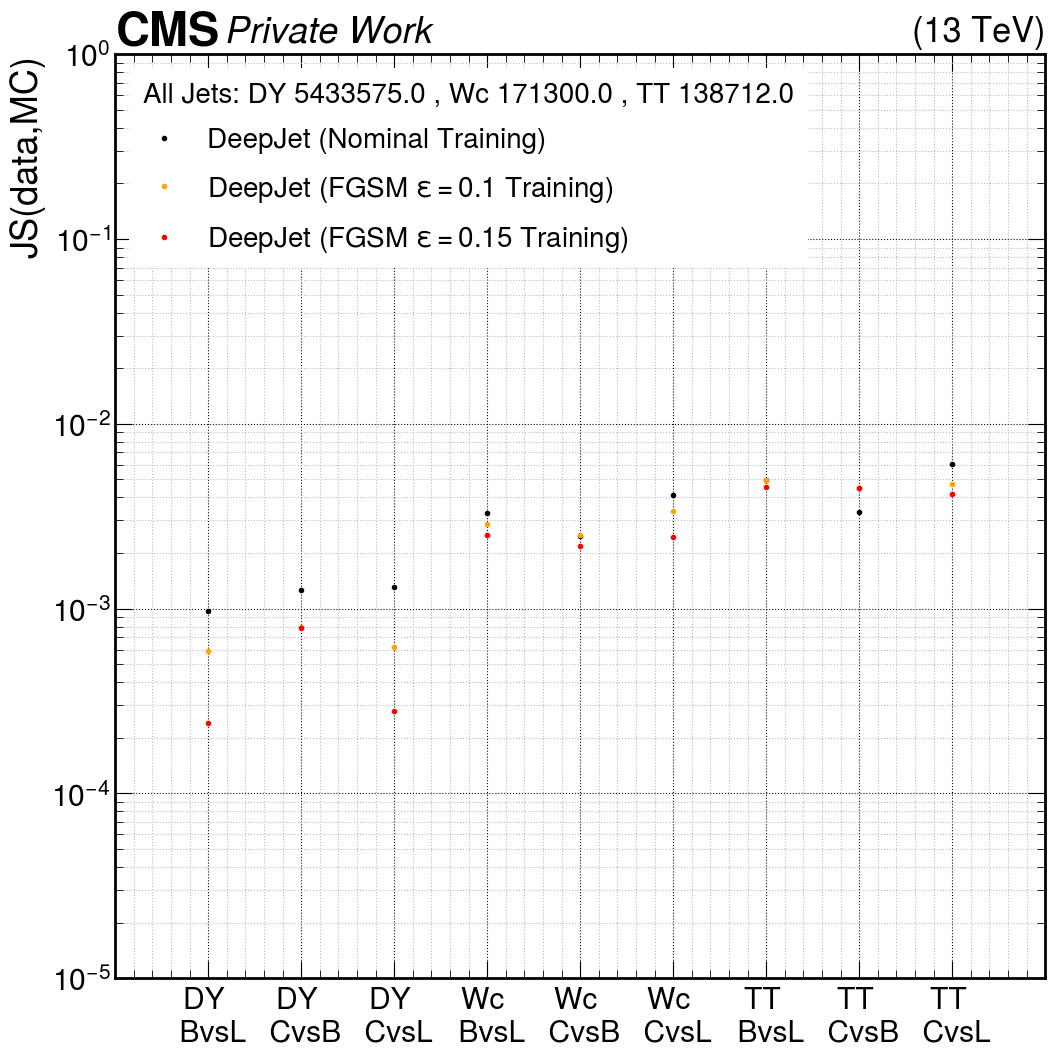

In [16]:
# calculate JS divergence values for all models

models = ['nominal','fgsm-0_1','fgsm-0_15']#]#]
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']
include_DPnote = True # optional: include JS values from DPnote in LaTeX table?

js_table = np.zeros((len(models),len(selections)*len(discriminators)))
N_selection = []
for i,model in enumerate(models):
    # nominal model is saved in the other directories
    if model=='nominal':
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{models[1]}/systPlots_2023/output_2017_PFNano_central' 
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
    for j,selection in enumerate(selections):
        for k,discriminator in enumerate(discriminators):
            if model=='nominal':
                histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
            else:
                histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
            # get Data and MC sum
            data = histo['Data'].values()
            MCsum = histo['MCSum'].values()
            if i==0 and k==0:
                N_selection.append(np.sum(data))
            MCsum[(MCsum==0)&(data!=0)] = 0.00001
            negative_values = (data<0) | (MCsum<0)
            data[negative_values] = 0
            MCsum[negative_values] = 0 
            js_value = jsdiv(data, MCsum, normalize_first=True)
            js_table[i,j*len(discriminators)+k] = js_value
print(js_table)
title = 'All Jets: DY {} , Wc {} , TT {}'.format(N_selection[0],N_selection[1],N_selection[2])
save_name = ''
plotJS(js_table, models, selections, discriminators, title=title, save_name=save_name)
JS_Latex(js_table, models, selections, discriminators)

pt [0,50] , eta [-3,-1] , DY_m : data 793793.0 , MC 793793.0000000001
pt [0,50] , eta [-3,-1] , Wc_m : data 24765.0 , MC 24765.000000000007
pt [0,50] , eta [-3,-1] , TT_semim : data 8879.0 , MC 8878.999999999998


/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00162543 0.0018967  0.00174573 0.01047527 0.00613391 0.01483379
  0.00776975 0.00622362 0.00882515]
 [0.00127562 0.00121478 0.00099494 0.00838105 0.00561667 0.00856734
  0.00823067 0.00660918 0.00703001]
 [0.00027721 0.00121031 0.00035468 0.01101085 0.00702913 0.00849522
  0.00657506 0.00668637 0.0061114 ]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001625 & 0.001897 & 0.001746 & 0.010475 & 0.006134 & 0.014834 & 0.007770 & $\textbf{0.006224}$ & 0.008825 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001276 & 0.001215 & 0.000995 & $\textbf{0.008381}$ & $\textbf{0.005617}$ & 0.008567 & 0.008231 & 0.006609 & 0.007030 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000277}$ & $\textbf{0.001210}$ & $\

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00183085 0.00216622 0.00193136 0.0065557  0.01031649 0.00492463
  0.00581452 0.0043087  0.00696878]
 [0.00121062 0.00137568 0.00116789 0.00547474 0.00611688 0.00465167
  0.00554155 0.00482015 0.00604149]
 [0.0007758  0.0016612  0.00036726 0.00392564 0.00621227 0.00608376
  0.0050845  0.00486134 0.00454975]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001831 & 0.002166 & 0.001931 & 0.006556 & 0.010316 & 0.004925 & 0.005815 & $\textbf{0.004309}$ & 0.006969 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001211 & $\textbf{0.001376}$ & 0.001168 & 0.005475 & $\textbf{0.006117}$ & $\textbf{0.004652}$ & 0.005542 & 0.004820 & 0.006041 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000776}$ & 0.001661 & $\

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00154652 0.00192055 0.00168411 0.01039656 0.00538227 0.00828359
  0.00502313 0.00322584 0.00542757]
 [0.00103355 0.00112303 0.00092261 0.00624437 0.00751679 0.00786787
  0.00469102 0.00361131 0.00504185]
 [0.00067833 0.00141506 0.00037866 0.00699805 0.00601925 0.00506036
  0.00405912 0.00437416 0.00359914]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001547 & 0.001921 & 0.001684 & 0.010397 & $\textbf{0.005382}$ & 0.008284 & 0.005023 & $\textbf{0.003226}$ & 0.005428 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001034 & $\textbf{0.001123}$ & 0.000923 & $\textbf{0.006244}$ & 0.007517 & 0.007868 & 0.004691 & 0.003611 & 0.005042 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000678}$ & 0.001415 & $\

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00149579 0.00176973 0.00157011 0.0117383  0.0166015  0.01756644
  0.00731092 0.00525792 0.00831855]
 [0.00113258 0.00110143 0.00098857 0.01160988 0.00833753 0.01577732
  0.00727016 0.00690532 0.00812169]
 [0.0002462  0.00109077 0.00037612 0.01145447 0.01355253 0.00829635
  0.00665353 0.00703709 0.00750514]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001496 & 0.001770 & 0.001570 & 0.011738 & 0.016602 & 0.017566 & 0.007311 & $\textbf{0.005258}$ & 0.008319 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001133 & 0.001101 & 0.000989 & 0.011610 & $\textbf{0.008338}$ & 0.015777 & 0.007270 & 0.006905 & 0.008122 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000246}$ & $\textbf{0.001091}$ & $\textbf{0.00

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.0011838  0.0026665  0.00176786 0.01244674 0.01169095 0.01078204
  0.00466361 0.00312113 0.00632472]
 [0.00057337 0.00187145 0.00057731 0.00636692 0.00756478 0.00581421
  0.00476601 0.00489654 0.00518574]
 [0.00026686 0.00165093 0.00061328 0.00794653 0.01015102 0.00931239
  0.00500106 0.00549094 0.00468861]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001184 & 0.002666 & 0.001768 & 0.012447 & 0.011691 & 0.010782 & $\textbf{0.004664}$ & $\textbf{0.003121}$ & 0.006325 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000573 & 0.001871 & $\textbf{0.000577}$ & $\textbf{0.006367}$ & $\textbf{0.007565}$ & $\textbf{0.005814}$ & 0.004766 & 0.004897 & 0.005186 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.00

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00153762 0.00357927 0.00194881 0.00800924 0.01001157 0.00517224
  0.00367852 0.0026489  0.0050345 ]
 [0.00108483 0.00262371 0.00125442 0.00525661 0.01171668 0.00597748
  0.00392075 0.00372714 0.00370214]
 [0.00079496 0.00286531 0.00102436 0.00723089 0.0052334  0.00516199
  0.00346774 0.00388451 0.00327319]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001538 & 0.003579 & 0.001949 & 0.008009 & 0.010012 & 0.005172 & 0.003679 & $\textbf{0.002649}$ & 0.005034 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001085 & $\textbf{0.002624}$ & 0.001254 & $\textbf{0.005257}$ & 0.011717 & 0.005977 & 0.003921 & 0.003727 & 0.003702 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000795}$ & 0.002865 & $\textbf{0.00

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.0012713  0.00302612 0.00160907 0.01052803 0.01489063 0.01144637
  0.00392121 0.00310454 0.00511939]
 [0.00083158 0.00213665 0.00097275 0.00986493 0.01162649 0.0101521
  0.00388389 0.00396248 0.0038988 ]
 [0.00062764 0.00241497 0.00089364 0.01223029 0.01530882 0.01134554
  0.00358133 0.00387981 0.00332657]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001271 & 0.003026 & 0.001609 & 0.010528 & 0.014891 & 0.011446 & 0.003921 & $\textbf{0.003105}$ & 0.005119 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000832 & $\textbf{0.002137}$ & 0.000973 & $\textbf{0.009865}$ & $\textbf{0.011626}$ & $\textbf{0.010152}$ & 0.003884 & 0.003962 & 0.003899 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000628}$ & 0.0

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00138268 0.00285643 0.00164031 0.01459343 0.01170595 0.01446812
  0.00599333 0.00314668 0.00773854]
 [0.00068317 0.0019424  0.00049396 0.00878843 0.01776784 0.01086757
  0.00619967 0.00486588 0.0061933 ]
 [0.00027167 0.00170518 0.00046518 0.01611355 0.01710302 0.00744499
  0.00580123 0.0048131  0.00580958]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001383 & 0.002856 & 0.001640 & 0.014593 & $\textbf{0.011706}$ & 0.014468 & 0.005993 & $\textbf{0.003147}$ & 0.007739 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000683 & 0.001942 & 0.000494 & $\textbf{0.008788}$ & 0.017768 & 0.010868 & 0.006200 & 0.004866 & 0.006193 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000272}$ & $\textbf{0.001705}$ & $\

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.0016869  0.00357975 0.00200733 0.11333917 0.05083207 0.084095
  0.00743539 0.00720229 0.00859357]
 [0.00068483 0.00180534 0.00071149 0.05407084 0.06992978 0.05078835
  0.00785355 0.00769155 0.00665631]
 [0.00046236 0.00167462 0.00053909 0.06108823 0.07947986 0.08055453
  0.00795631 0.00666244 0.00776713]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001687 & 0.003580 & 0.002007 & 0.113339 & $\textbf{0.050832}$ & 0.084095 & $\textbf{0.007435}$ & 0.007202 & 0.008594 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000685 & 0.001805 & 0.000711 & $\textbf{0.054071}$ & 0.069930 & $\textbf{0.050788}$ & 0.007854 & 0.007692 & $\textbf{0.006656}$ \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000462}$ & $\te

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00161352 0.00410233 0.00203523 0.04295201 0.05530691 0.06936486
  0.00651315 0.00532636 0.00712809]
 [0.00108946 0.00292337 0.00097142 0.04716721 0.08525016 0.03662723
  0.00631255 0.00680752 0.00520738]
 [0.00102822 0.00292077 0.00107666 0.04931947 0.0279561  0.05990688
  0.00611578 0.00625352 0.00518108]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001614 & 0.004102 & 0.002035 & $\textbf{0.042952}$ & 0.055307 & 0.069365 & 0.006513 & $\textbf{0.005326}$ & 0.007128 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001089 & 0.002923 & $\textbf{0.000971}$ & 0.047167 & 0.085250 & $\textbf{0.036627}$ & 0.006313 & 0.006808 & 0.005207 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.001028}$ & $\textbf{0.00

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00167011 0.00386521 0.00206155 0.03817183 0.04382391 0.04647917
  0.00751458 0.00546947 0.00768215]
 [0.00125917 0.00279168 0.00119152 0.07784821 0.060465   0.04943639
  0.00727192 0.00774133 0.00641944]
 [0.00124297 0.00317062 0.00129909 0.03625073 0.07464882 0.04775626
  0.00760129 0.00719863 0.00624446]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001670 & 0.003865 & 0.002062 & 0.038172 & $\textbf{0.043824}$ & $\textbf{0.046479}$ & 0.007515 & $\textbf{0.005469}$ & 0.007682 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.001259 & $\textbf{0.002792}$ & $\textbf{0.001192}$ & 0.077848 & 0.060465 & 0.049436 & $\textbf{0.007272}$ & 0.007741 & 0.006419 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.00

/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_36346/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00173061 0.00327758 0.00159113 0.04942941 0.04317993 0.09563027
  0.00702154 0.00412912 0.00730531]
 [0.00068088 0.00158447 0.00040303 0.09195177 0.07075231 0.05550163
  0.00670401 0.00533715 0.00646202]
 [0.00045212 0.00154269 0.00037035 0.05880917 0.049851   0.05102284
  0.00664939 0.00661945 0.00636434]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001731 & 0.003278 & 0.001591 & $\textbf{0.049429}$ & $\textbf{0.043180}$ & 0.095630 & 0.007022 & $\textbf{0.004129}$ & 0.007305 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000681 & 0.001584 & 0.000403 & 0.091952 & 0.070752 & 0.055502 & 0.006704 & 0.005337 & 0.006462 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000452}$ & $\textbf{0.001543}$ & $\

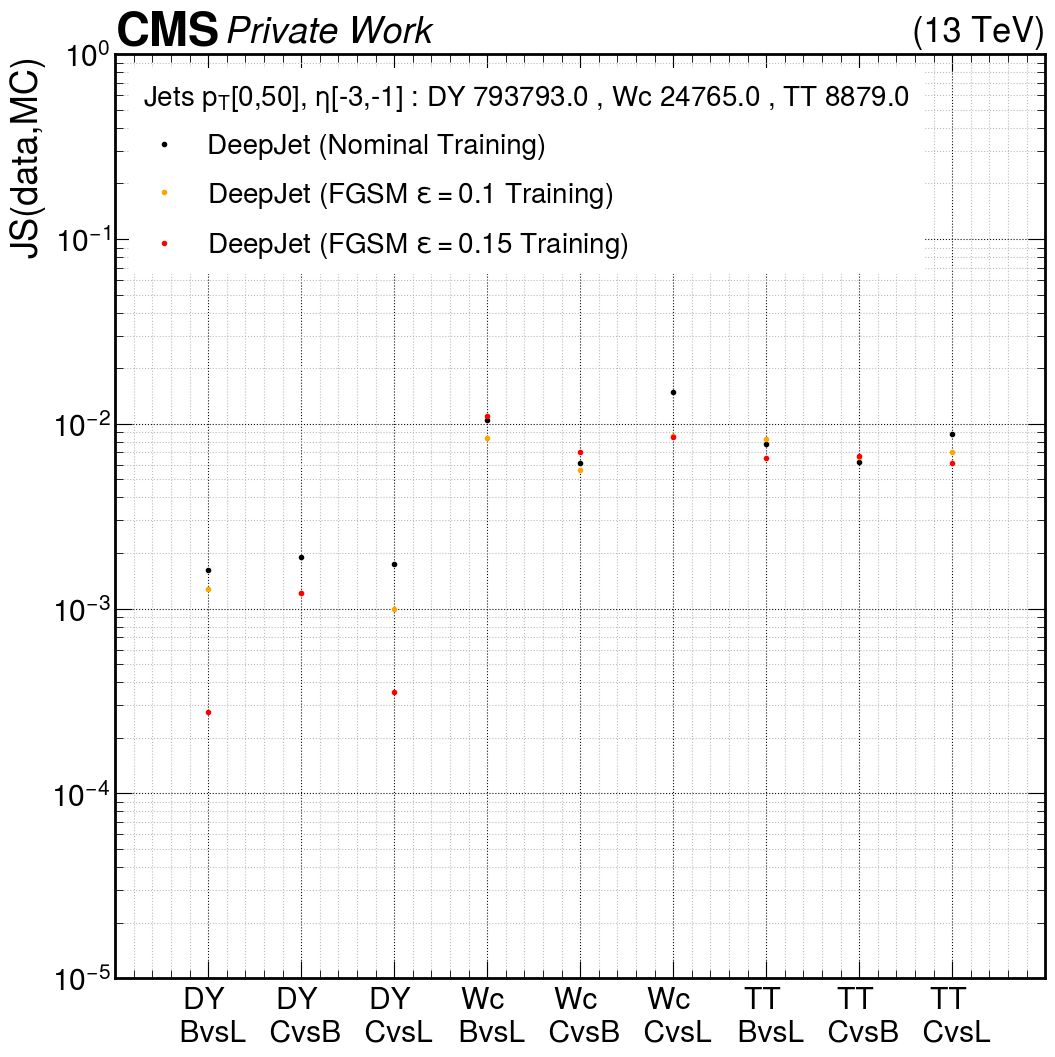

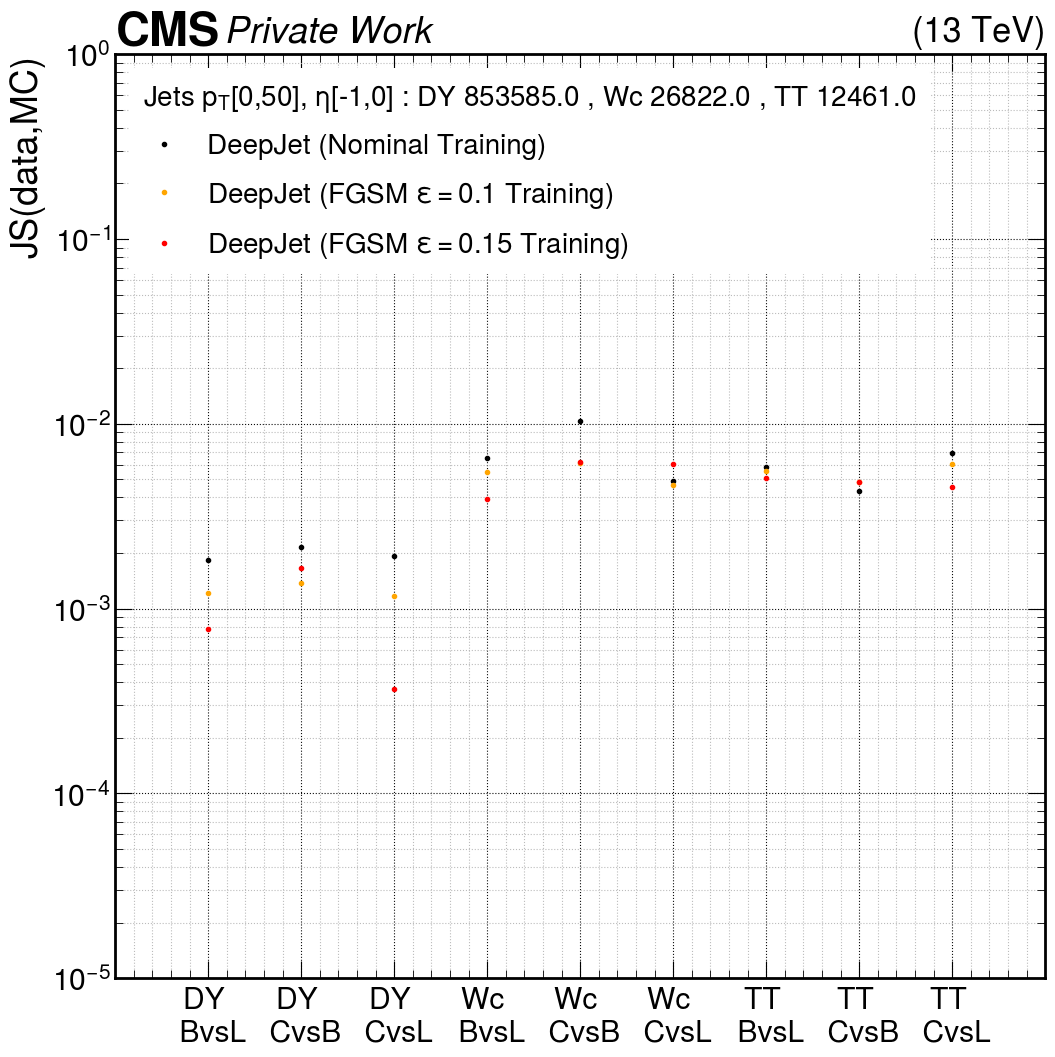

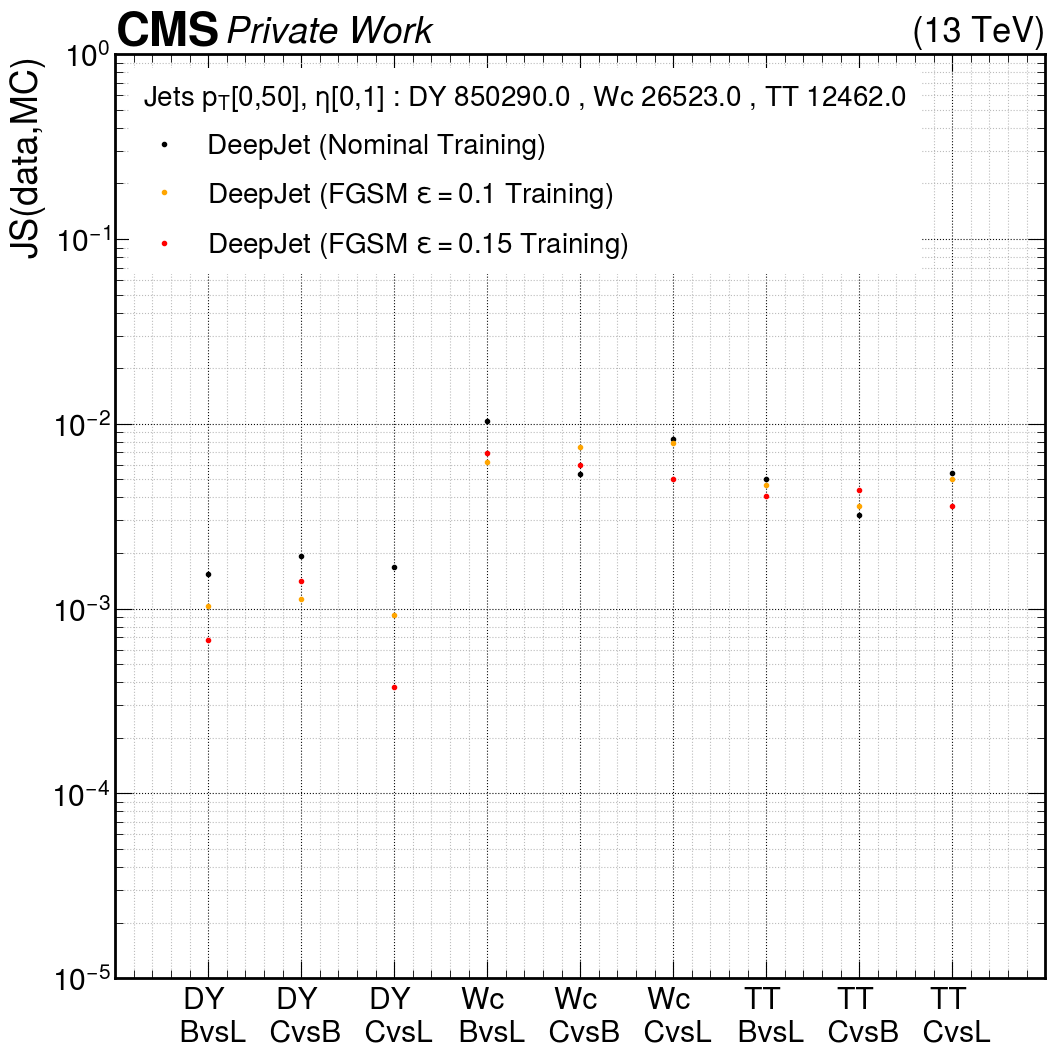

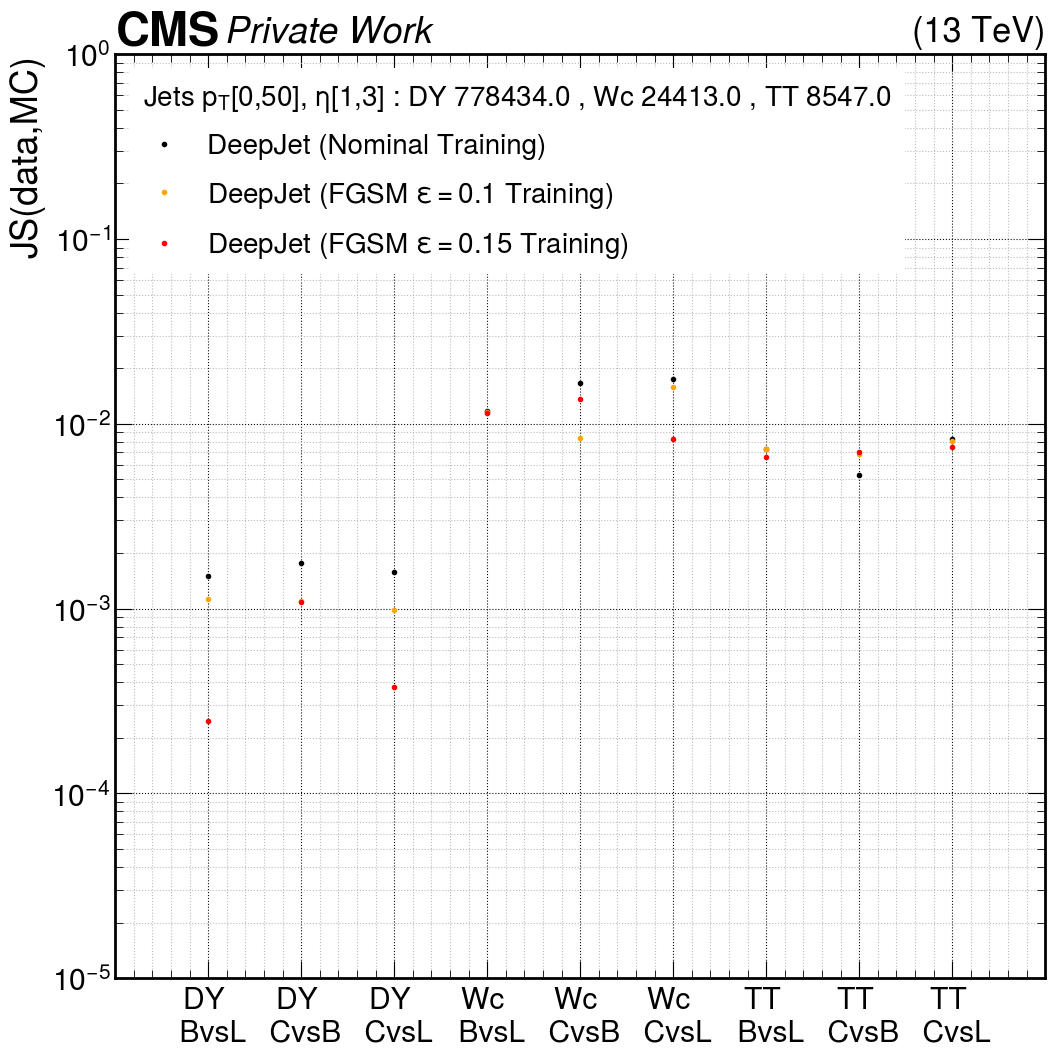

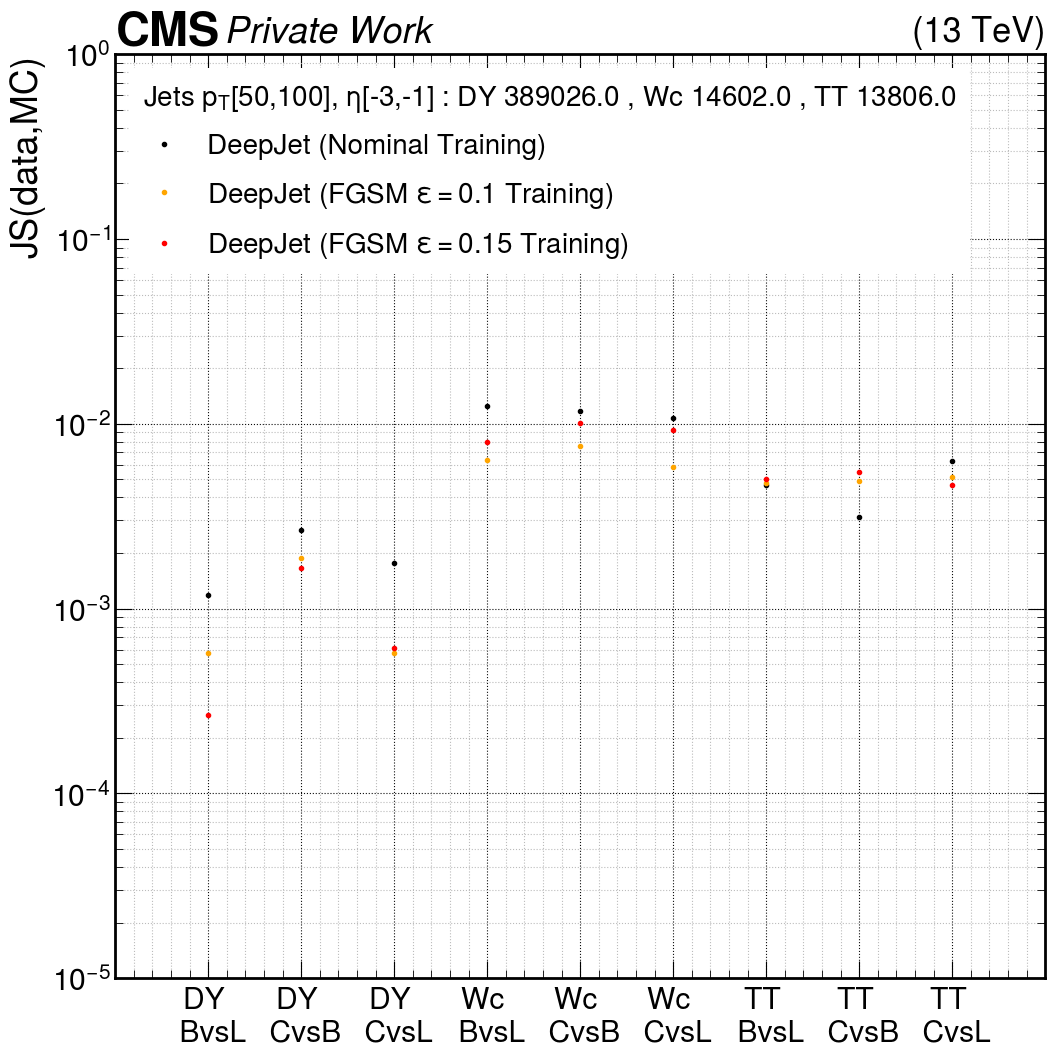

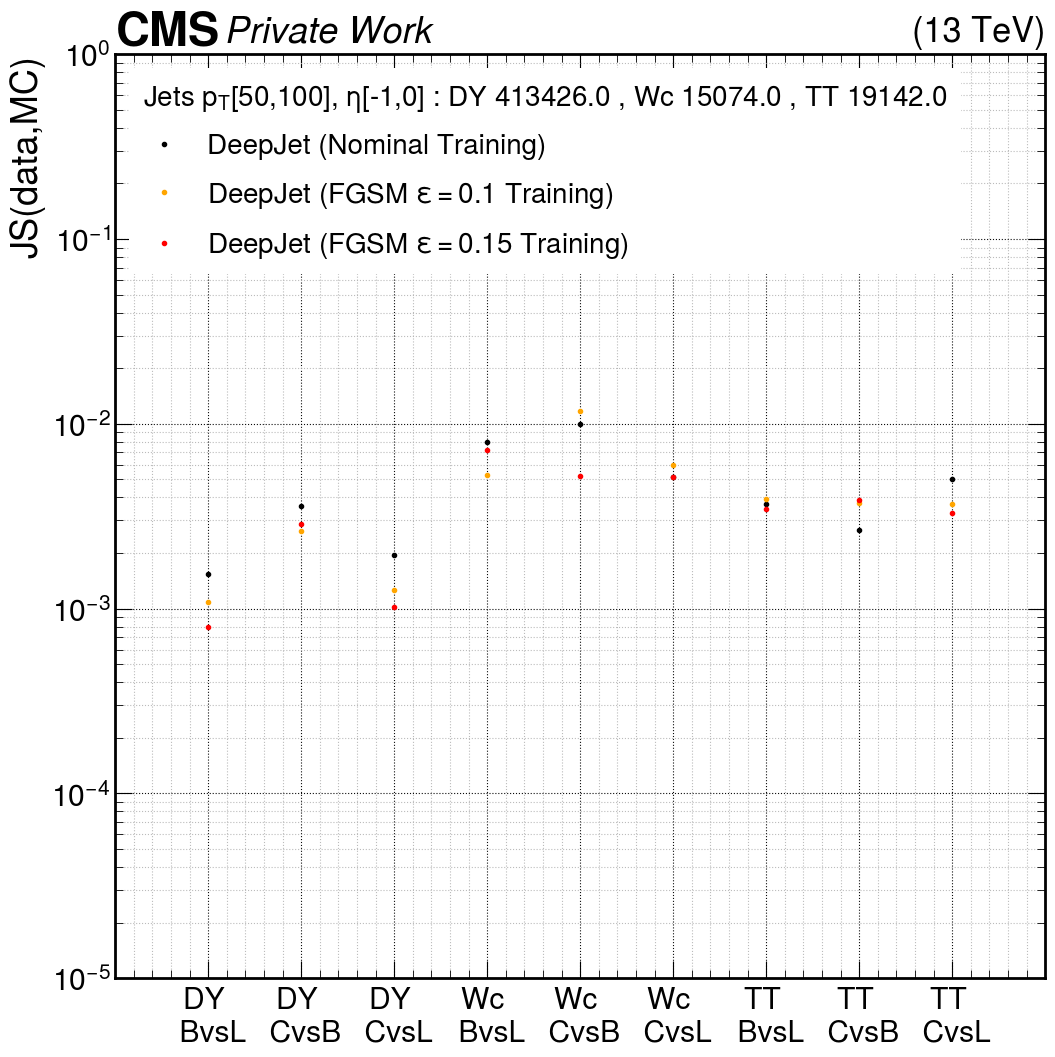

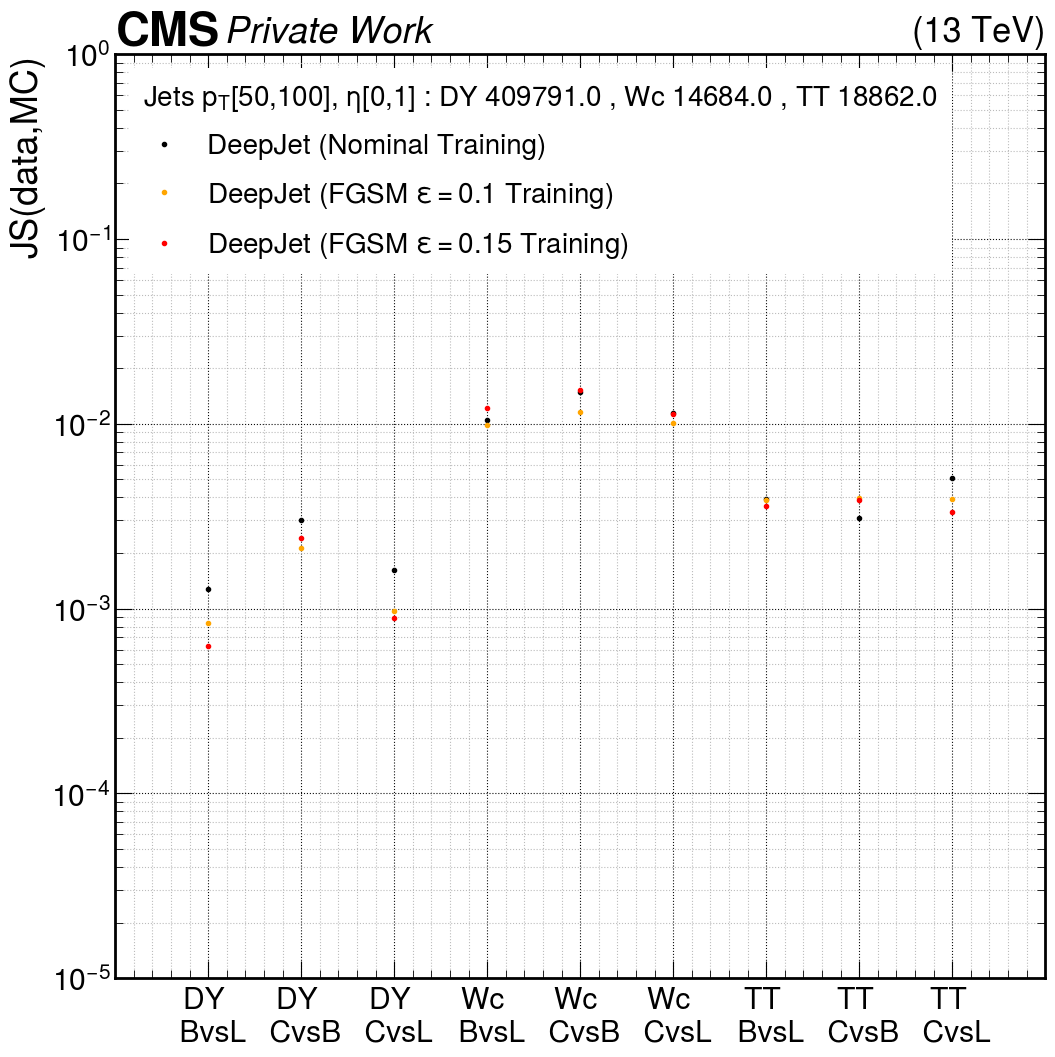

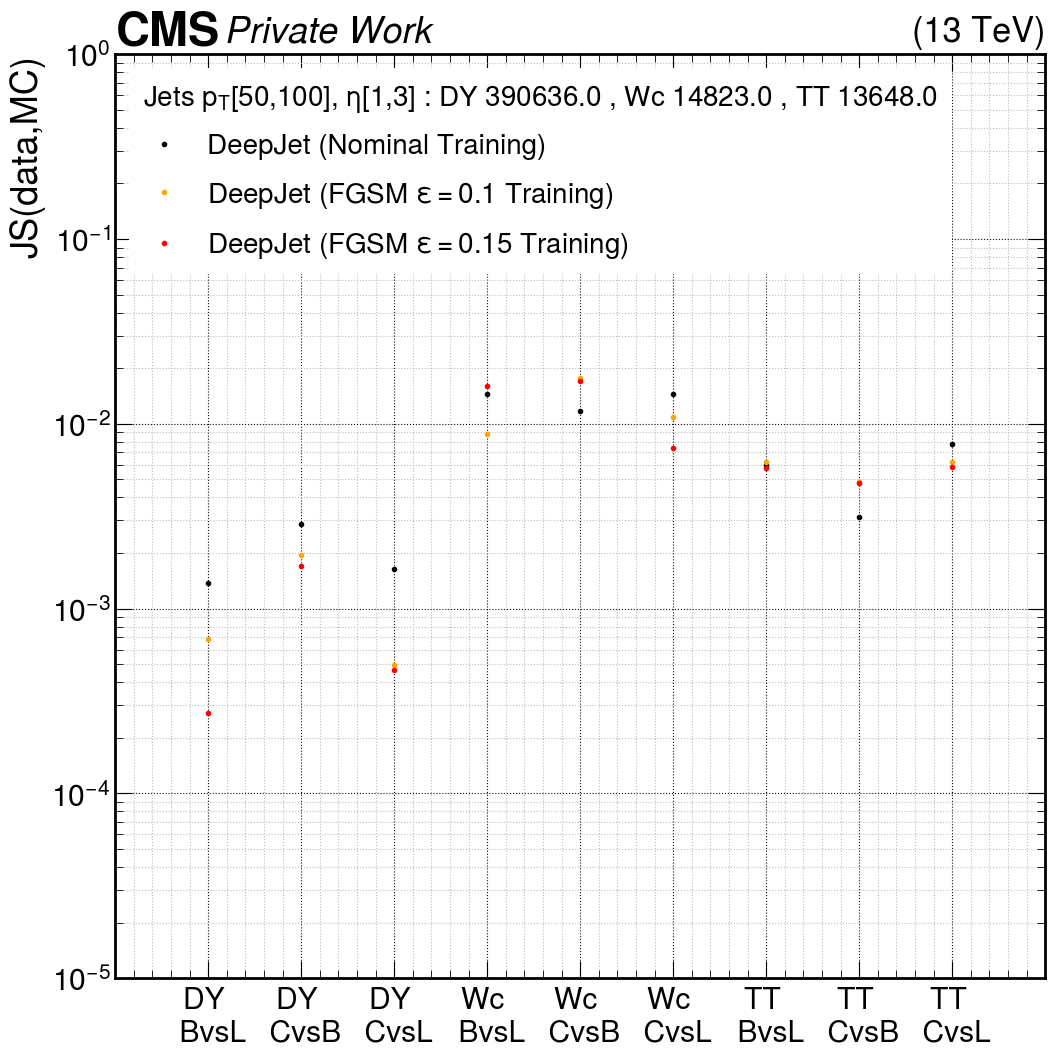

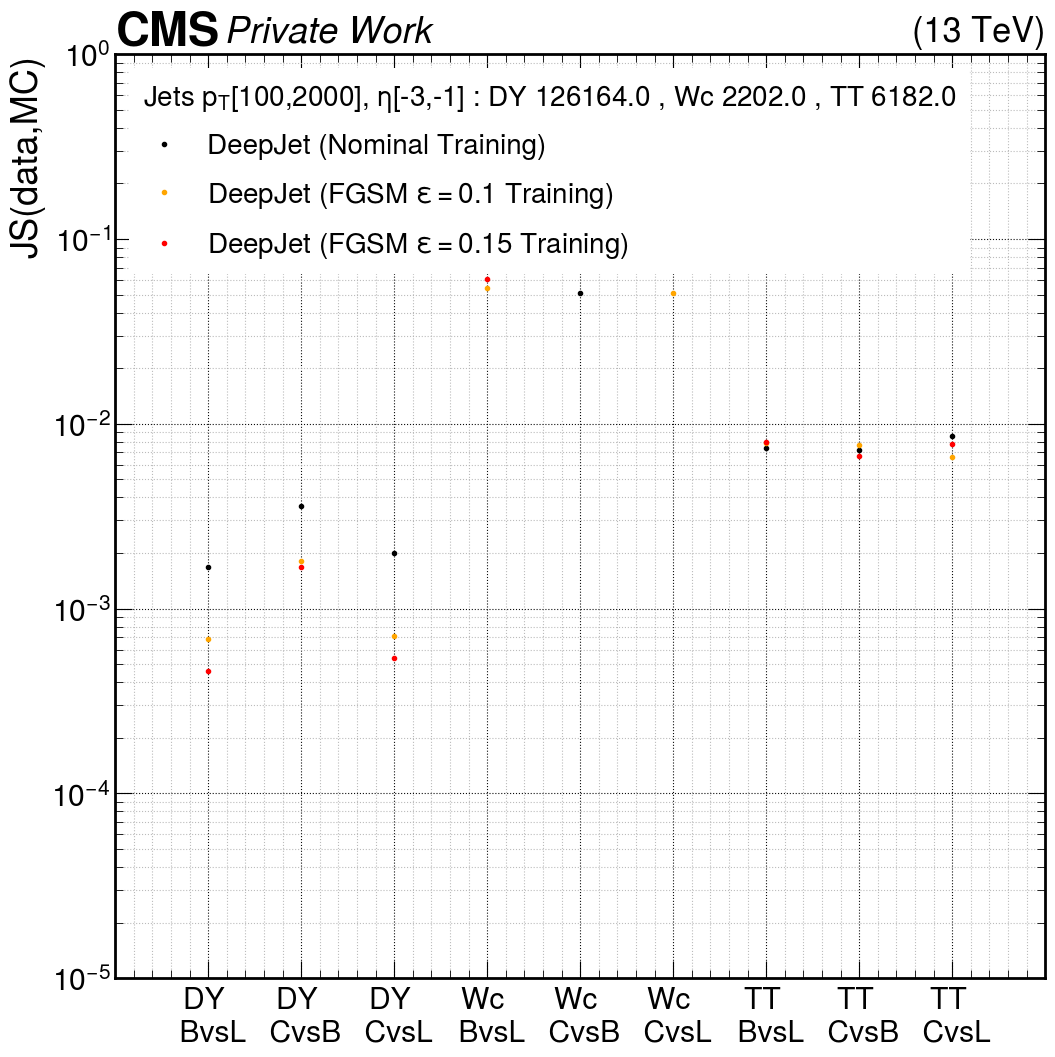

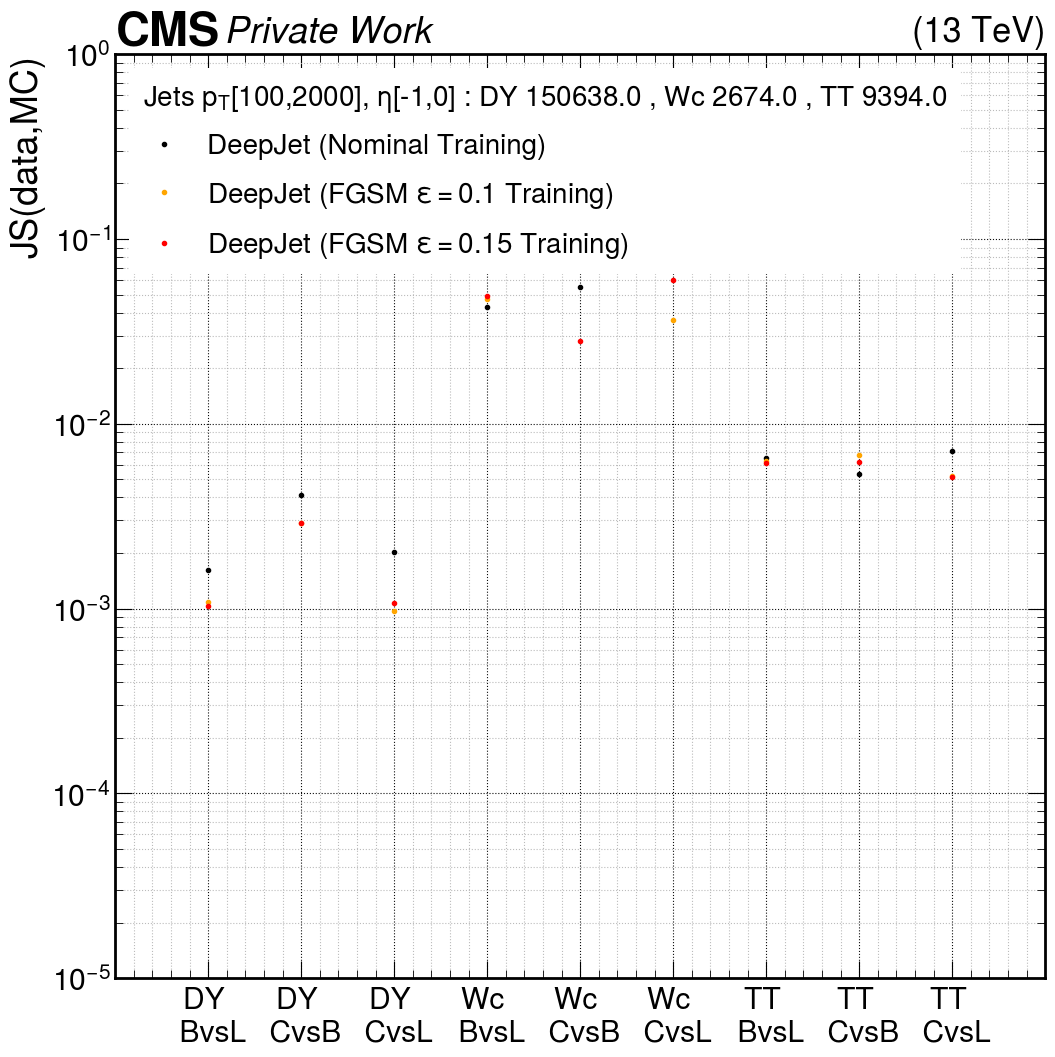

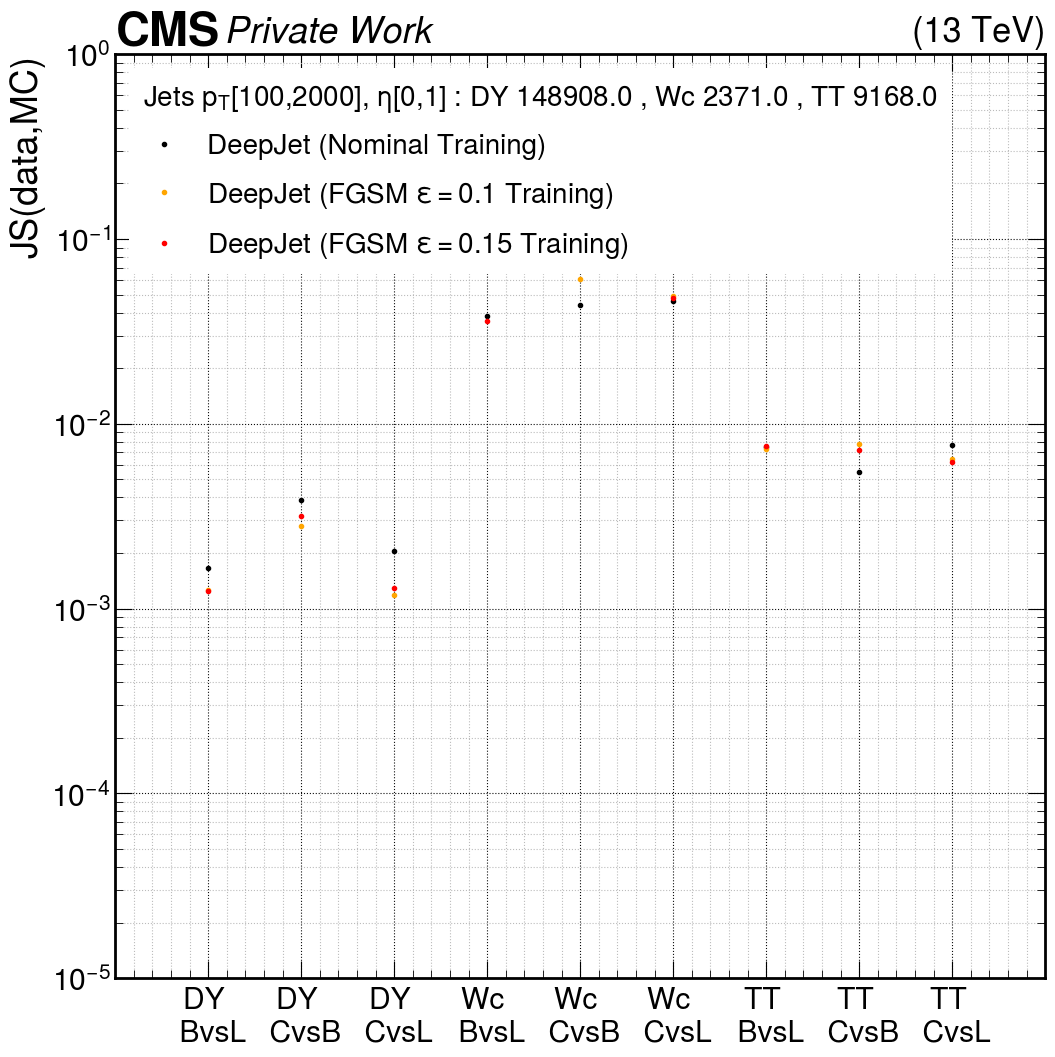

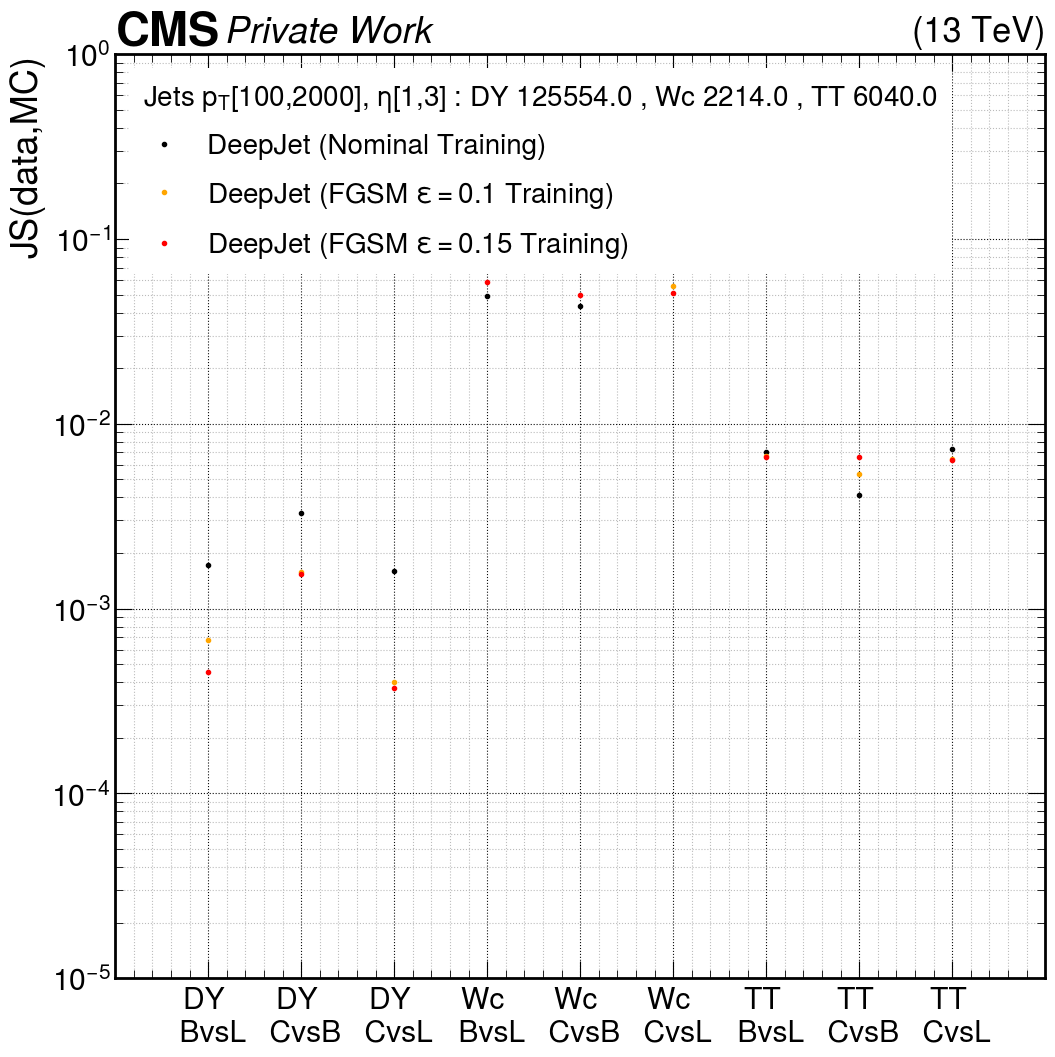

In [17]:
# calculate JS divergence values for all models with (pT,eta) selection

models = ['nominal','fgsm-0_1','fgsm-0_15']#]#]
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']

pt_edges = [0,50,100,2000]
eta_edges = [-3,-1,0,1,3]

include_DPnote = False # optional: include JS values from DPnote in LaTeX table?
for ind_pt in range(len(pt_edges)-1):
    pt_min = pt_edges[ind_pt]
    pt_max = pt_edges[ind_pt+1]
    for ind_eta in range(len(eta_edges)-1):
        eta_min = eta_edges[ind_eta]
        eta_max = eta_edges[ind_eta+1]
        js_table = np.zeros((len(models),len(selections)*len(discriminators)))
        N_selection = []
        for i,model in enumerate(models):
            # nominal model is saved in the other directories
            if model=='nominal':
                path = f'/nfs/dust/cms/user/hschonen/DataMC/{models[1]}/systPlots_2023/output_2017_PFNano_central' 
                #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
            else:
                path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
                #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
            for j,selection in enumerate(selections):
                for k,discriminator in enumerate(discriminators):
                    if model=='nominal':
                        histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_pt_{pt_min}-{pt_max}_eta_{eta_min}-{eta_max}_.root')
                        #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                    else:
                        histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_pt_{pt_min}-{pt_max}_eta_{eta_min}-{eta_max}_.root')
                        #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                    # get Data and MC sum
                    data = histo['Data'].values()
                    MCsum = histo['MCSum'].values()
                    if i==0 and k==0:
                        N_selection.append(np.sum(data))
                        print(f'pt [{pt_min},{pt_max}] , eta [{eta_min},{eta_max}] , {selection} : data {np.sum(data)} , MC {np.sum(MCsum)}')
                    MCsum[(MCsum==0)&(data!=0)] = 0.00001
                    negative_values = (data<0) | (MCsum<0)
                    data[negative_values] = 0
                    MCsum[negative_values] = 0 
                    js_value = jsdiv(data, MCsum, normalize_first=True)
                    js_table[i,j*len(discriminators)+k] = js_value
        print(js_table)
        title = 'Jets $p_{T}$'+f'[{pt_min},{pt_max}]'+', $\eta$'+f'[{eta_min},{eta_max}]'+' : DY {} , Wc {} , TT {}'.format(N_selection[0],N_selection[1],N_selection[2])
        save_name = f'_pt_{pt_min}-{pt_max}_eta_{eta_min}-{eta_max}'
        plotJS(js_table, models, selections, discriminators, title=title, save_name=save_name)
        JS_Latex(js_table, models, selections, discriminators)

/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={"height_ratios": (3, 1), 'hspace': 0.0}, sharex=True)
/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_4150/837590782.py:140: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_4150/837590782.py:141: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


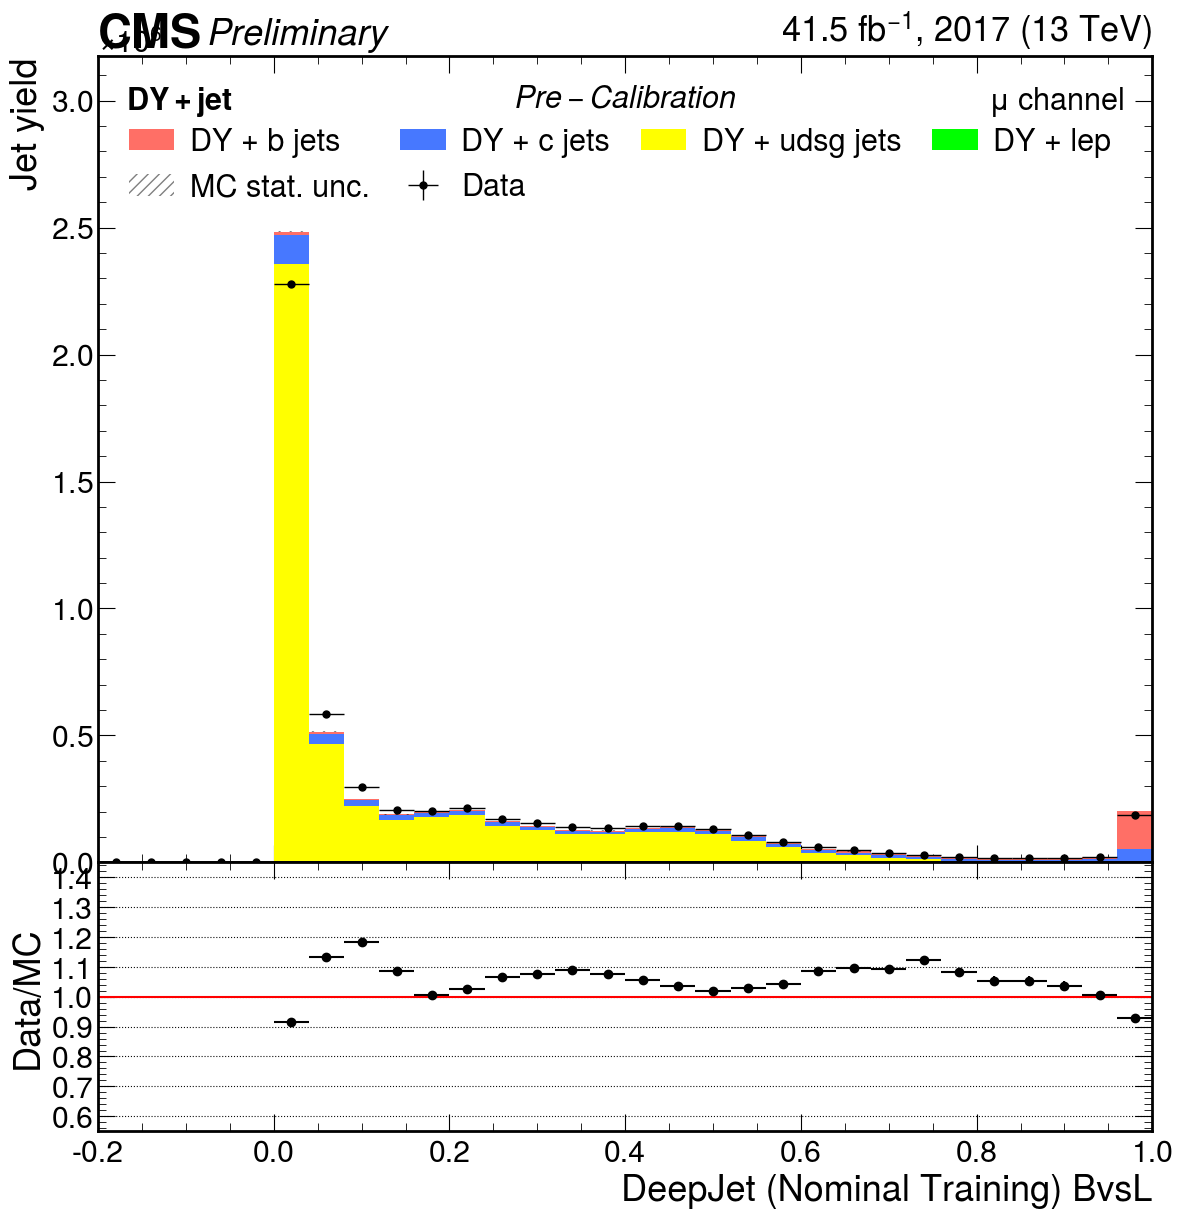

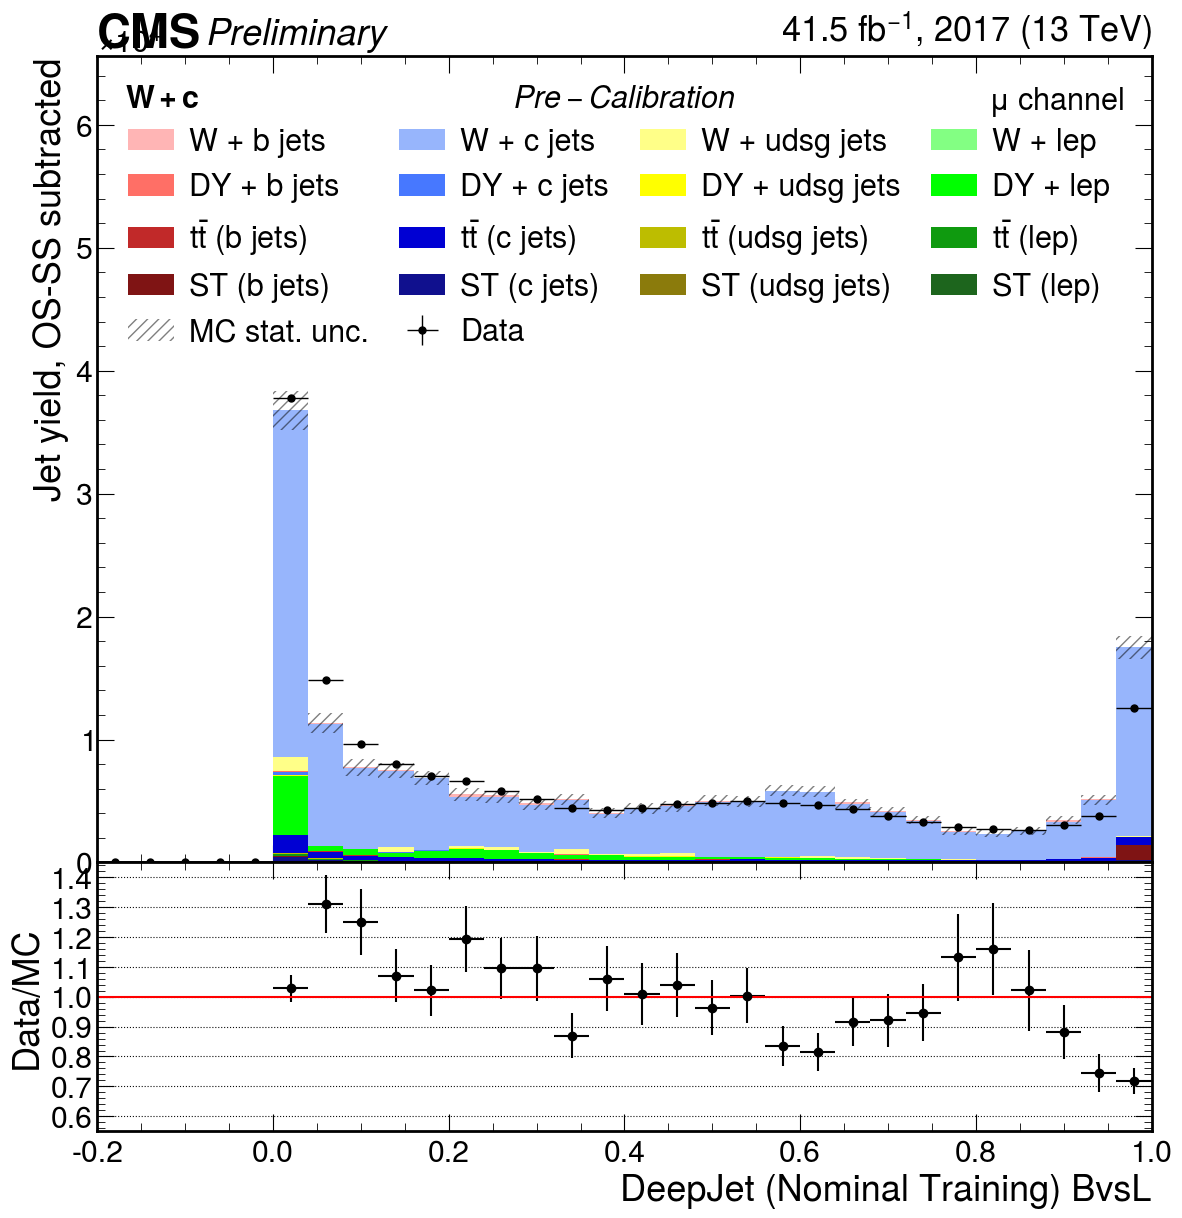

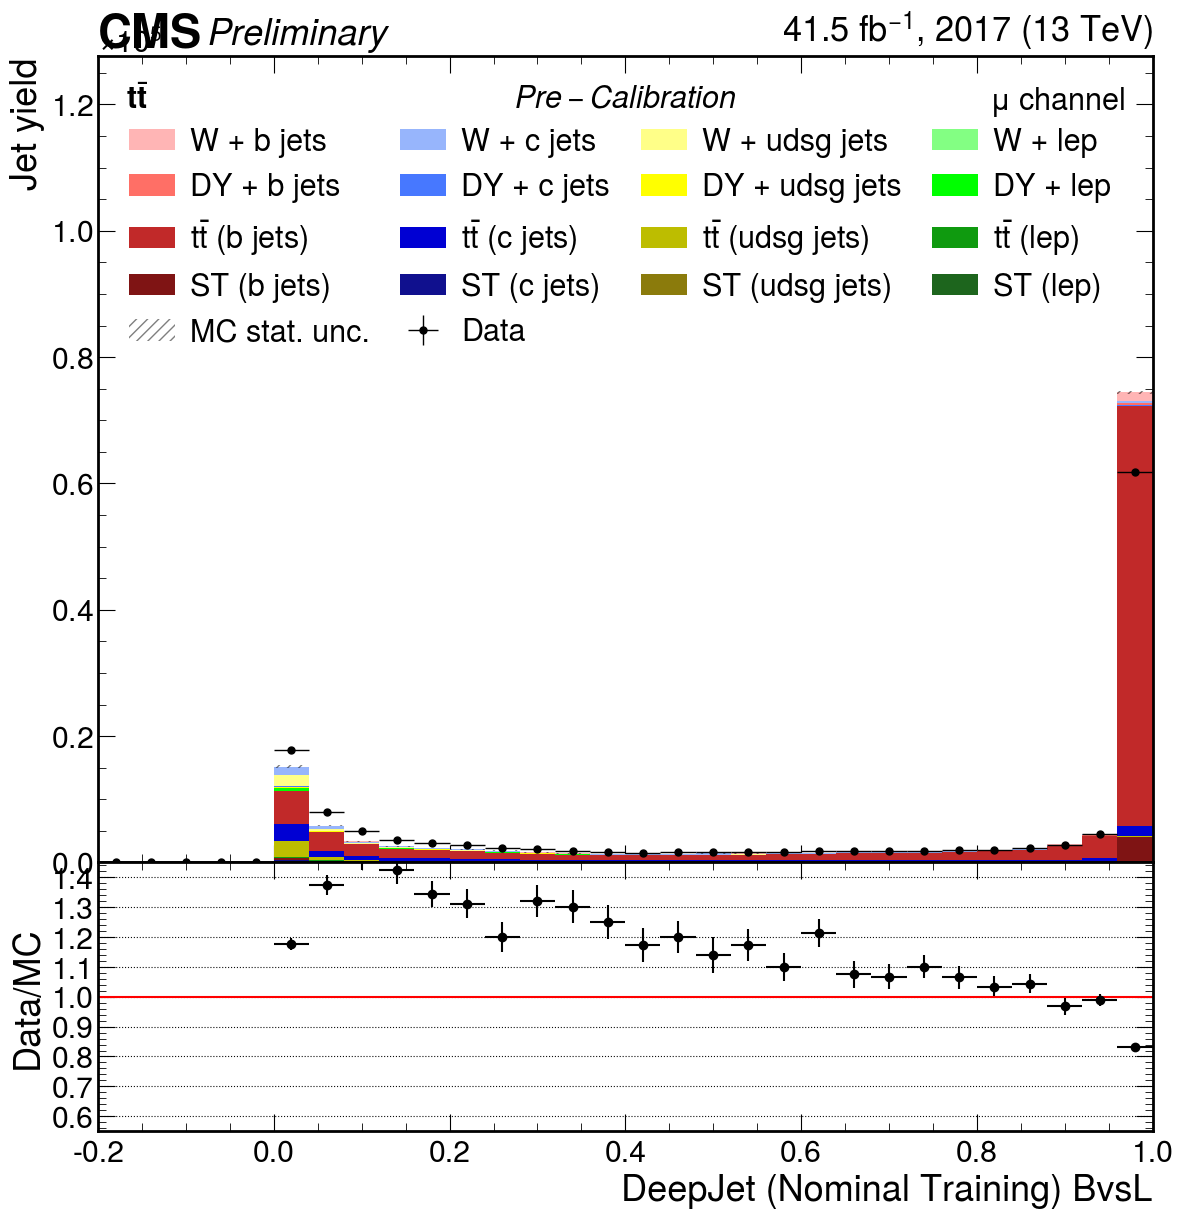

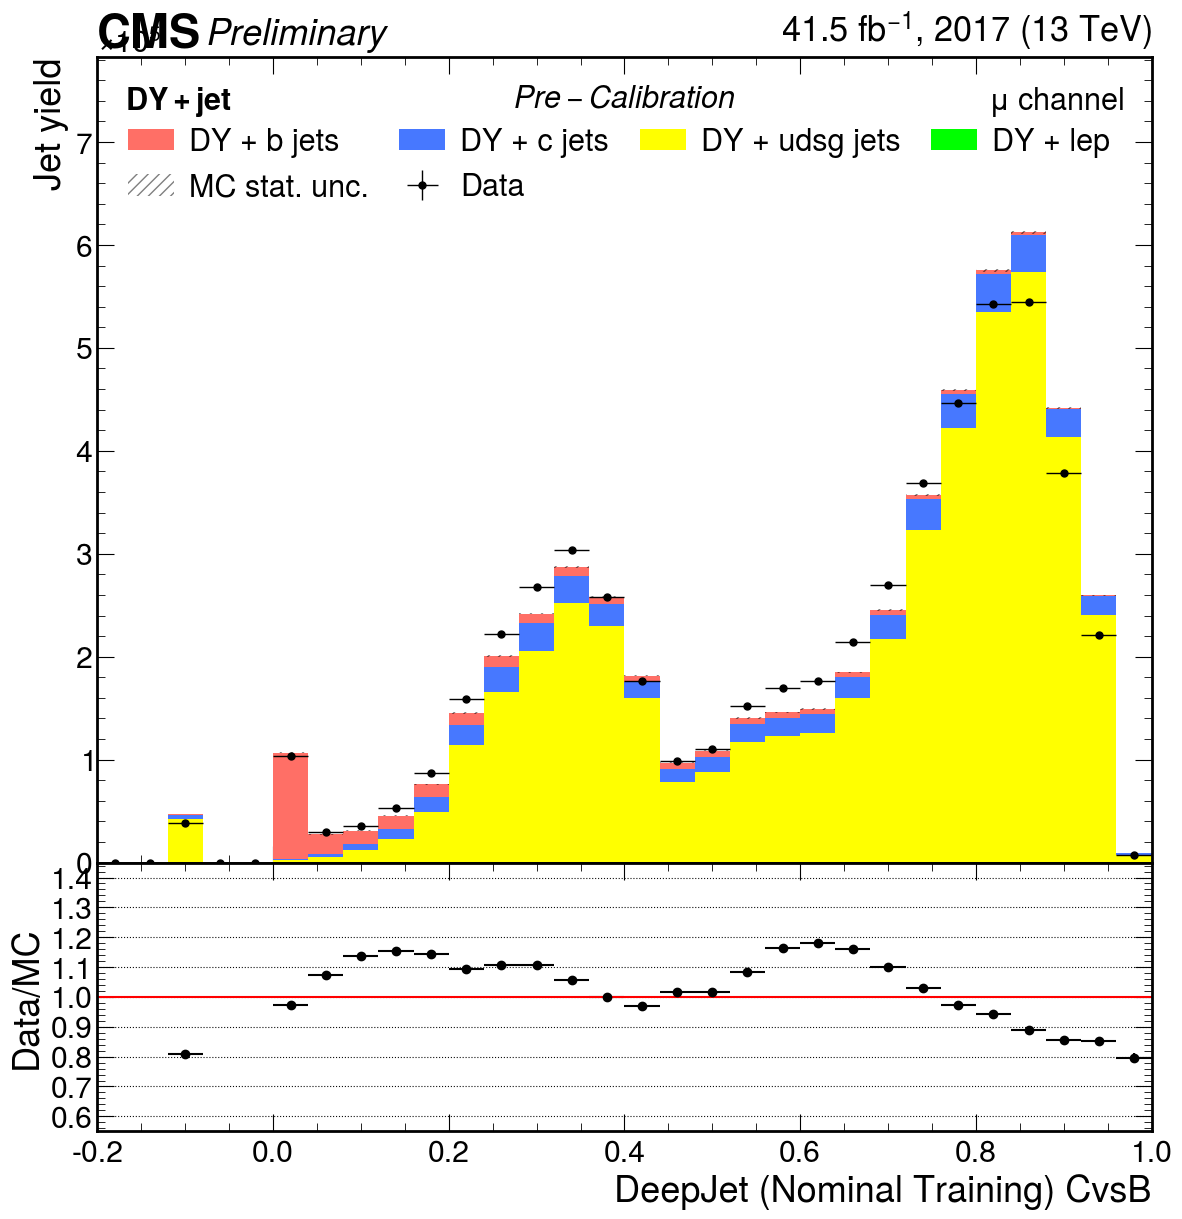

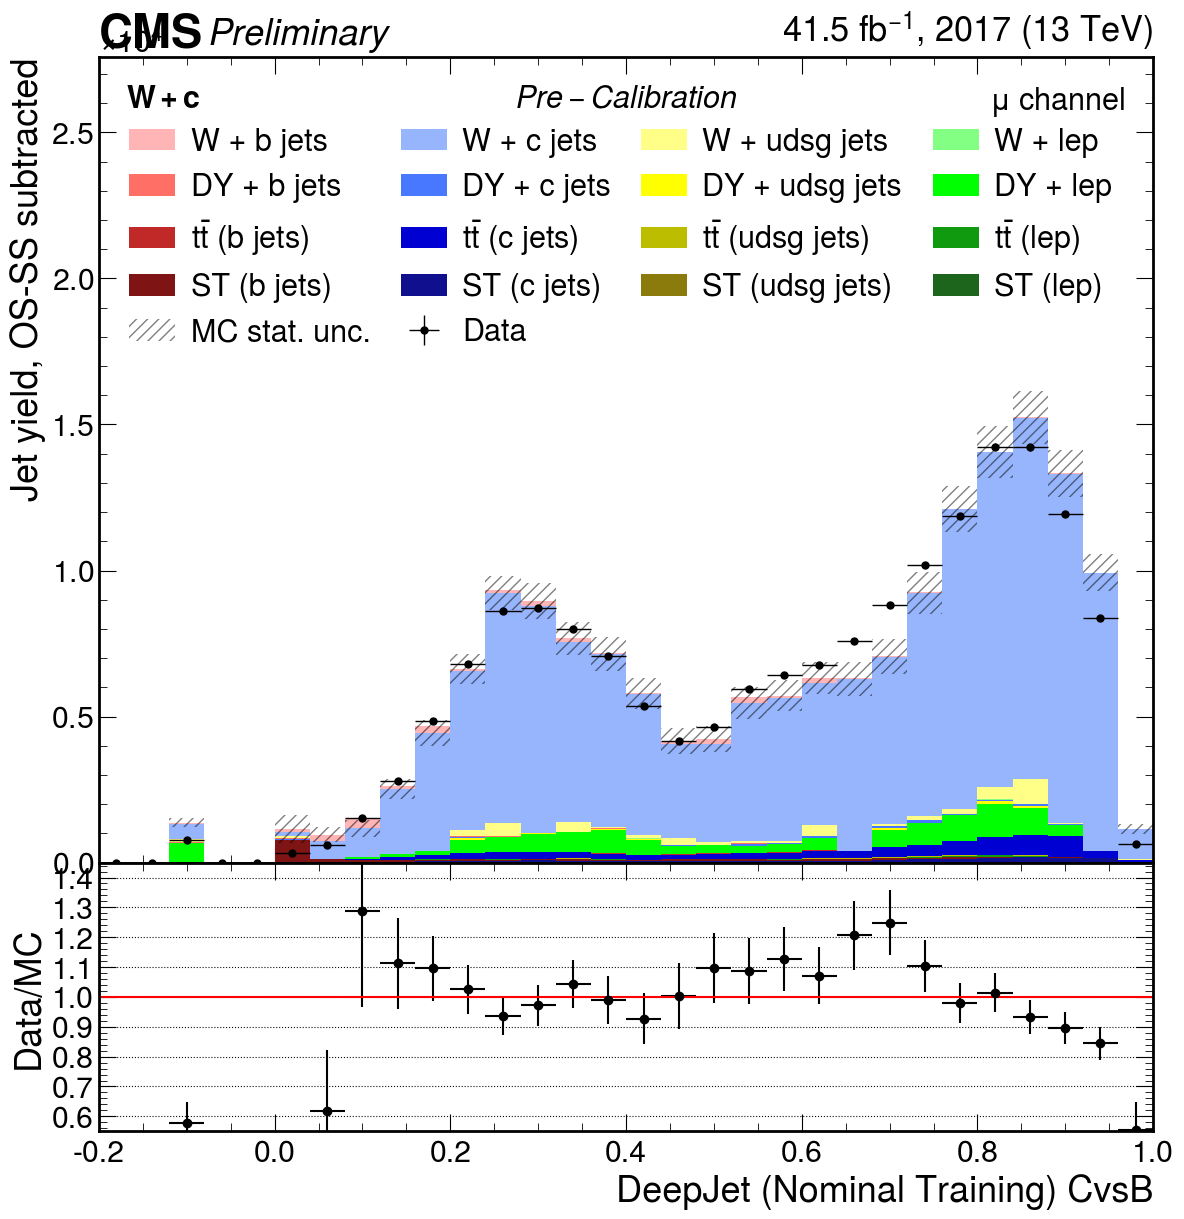

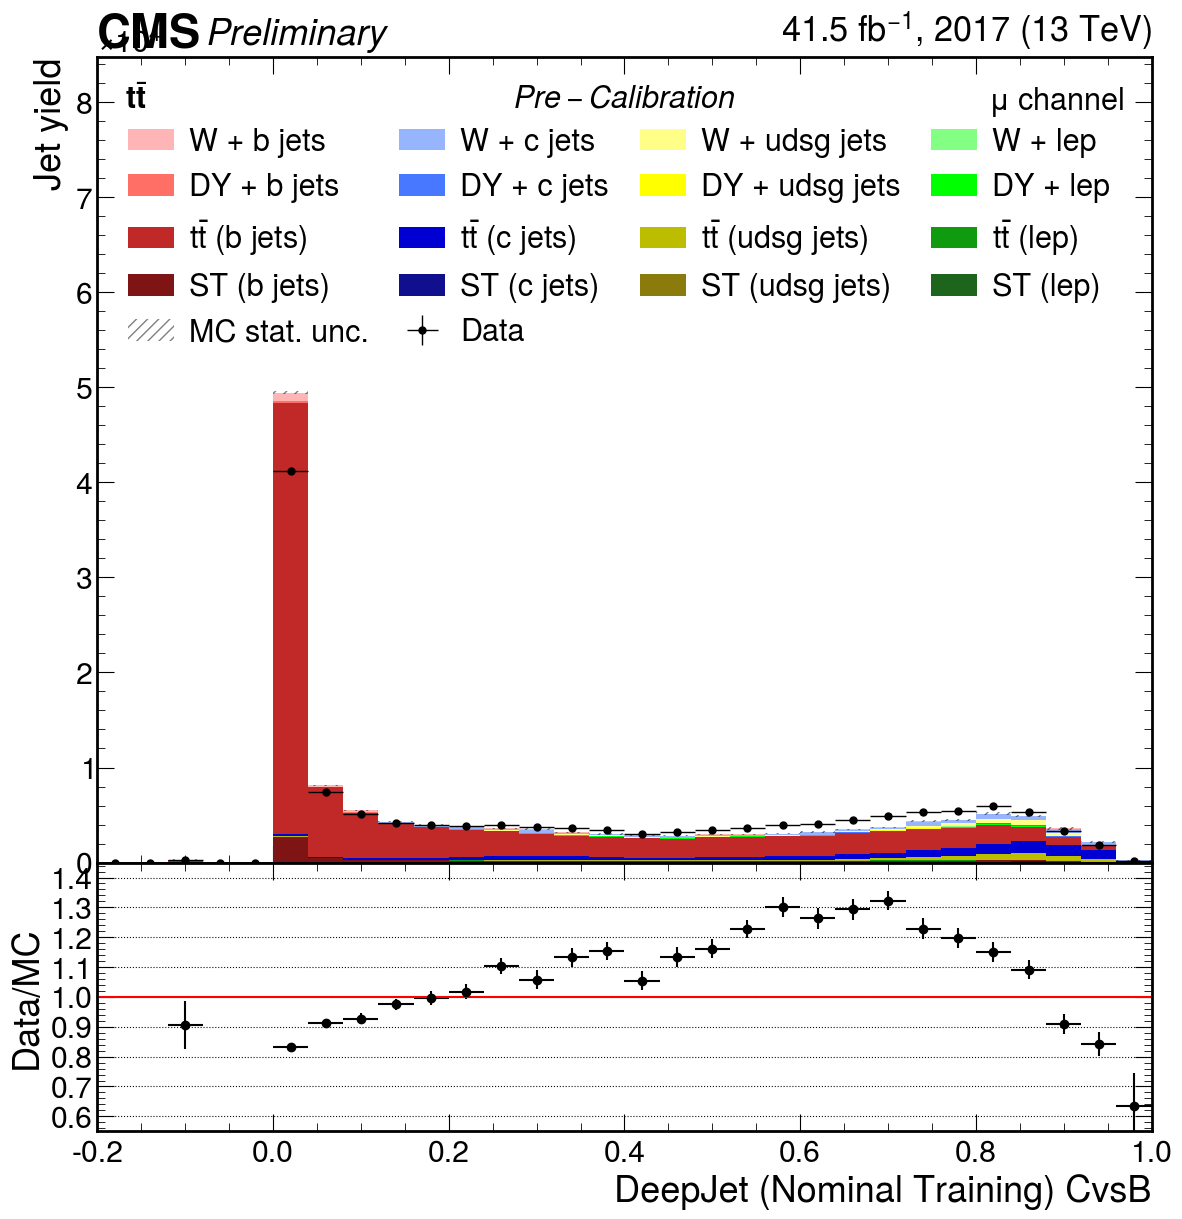

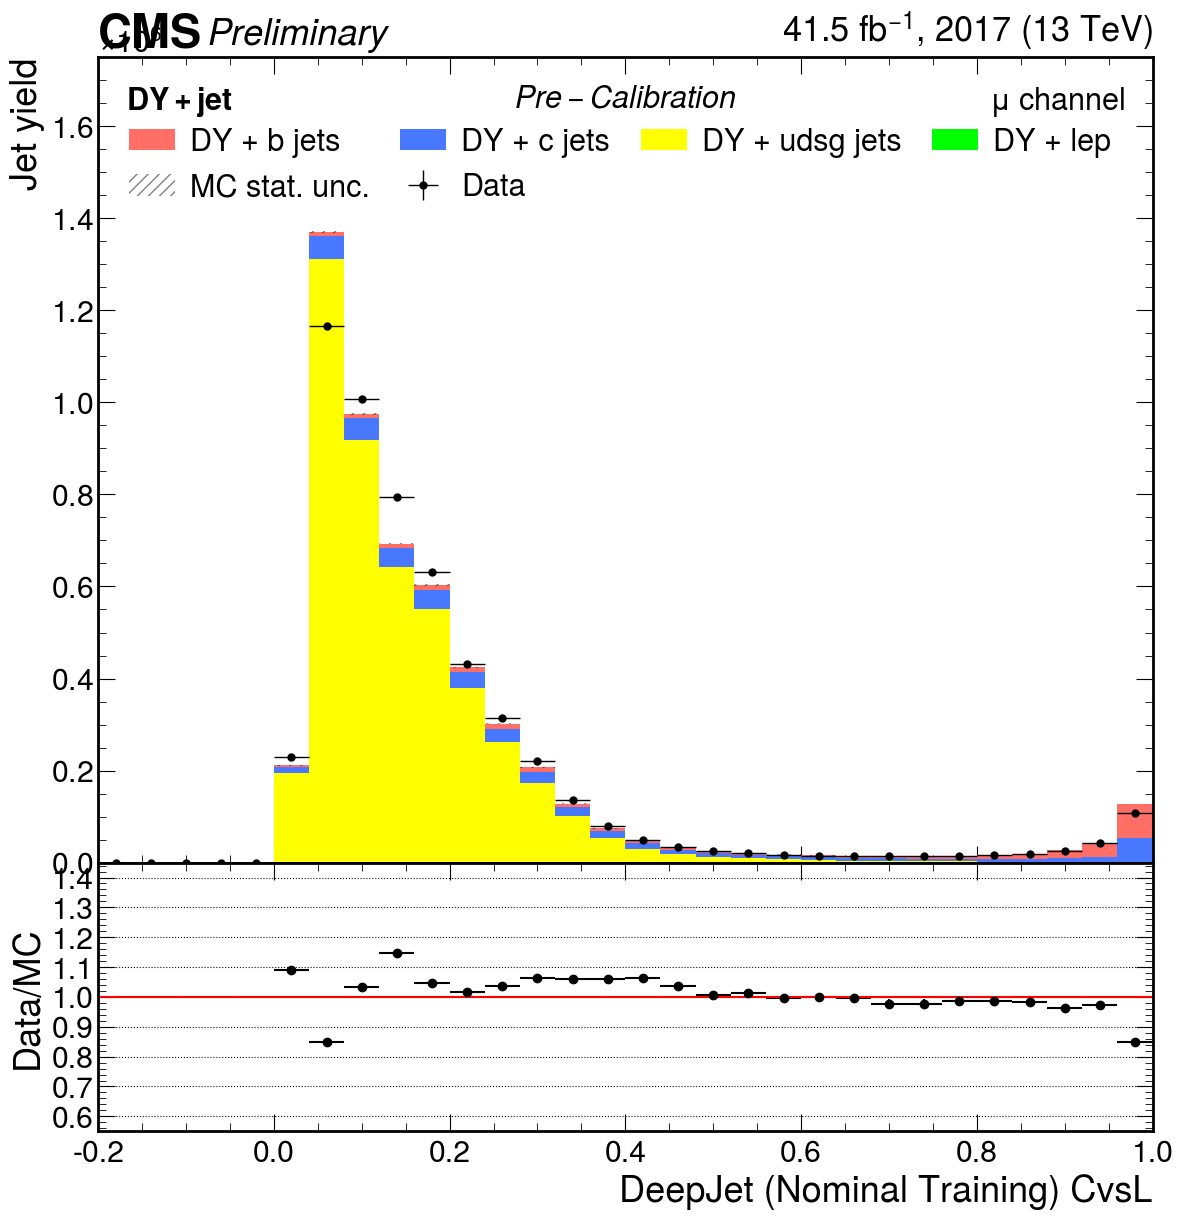

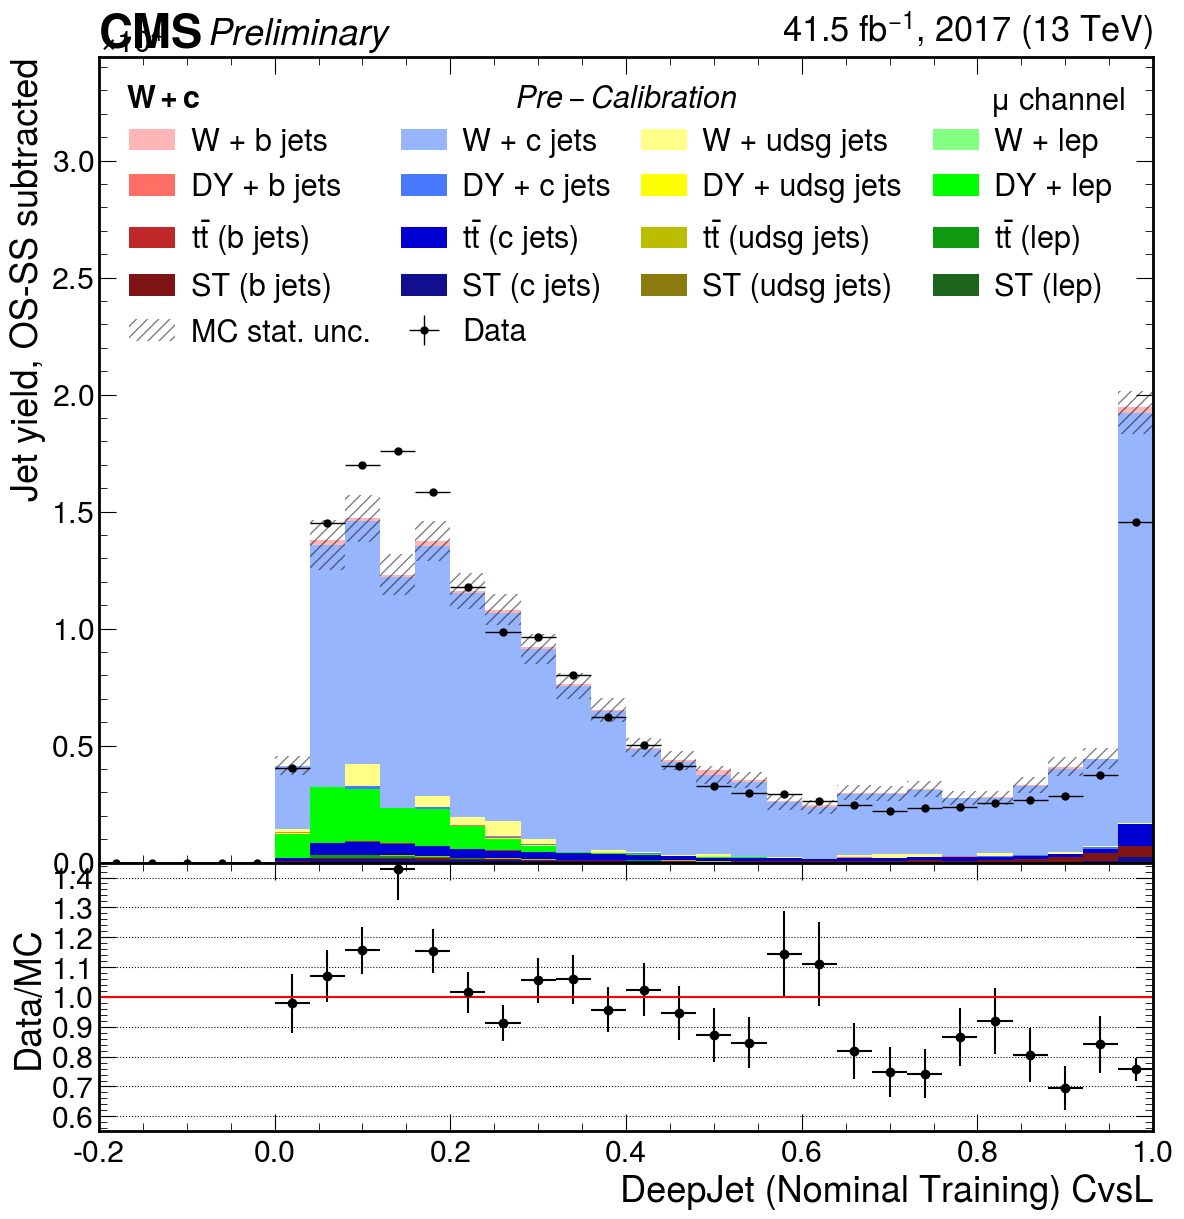

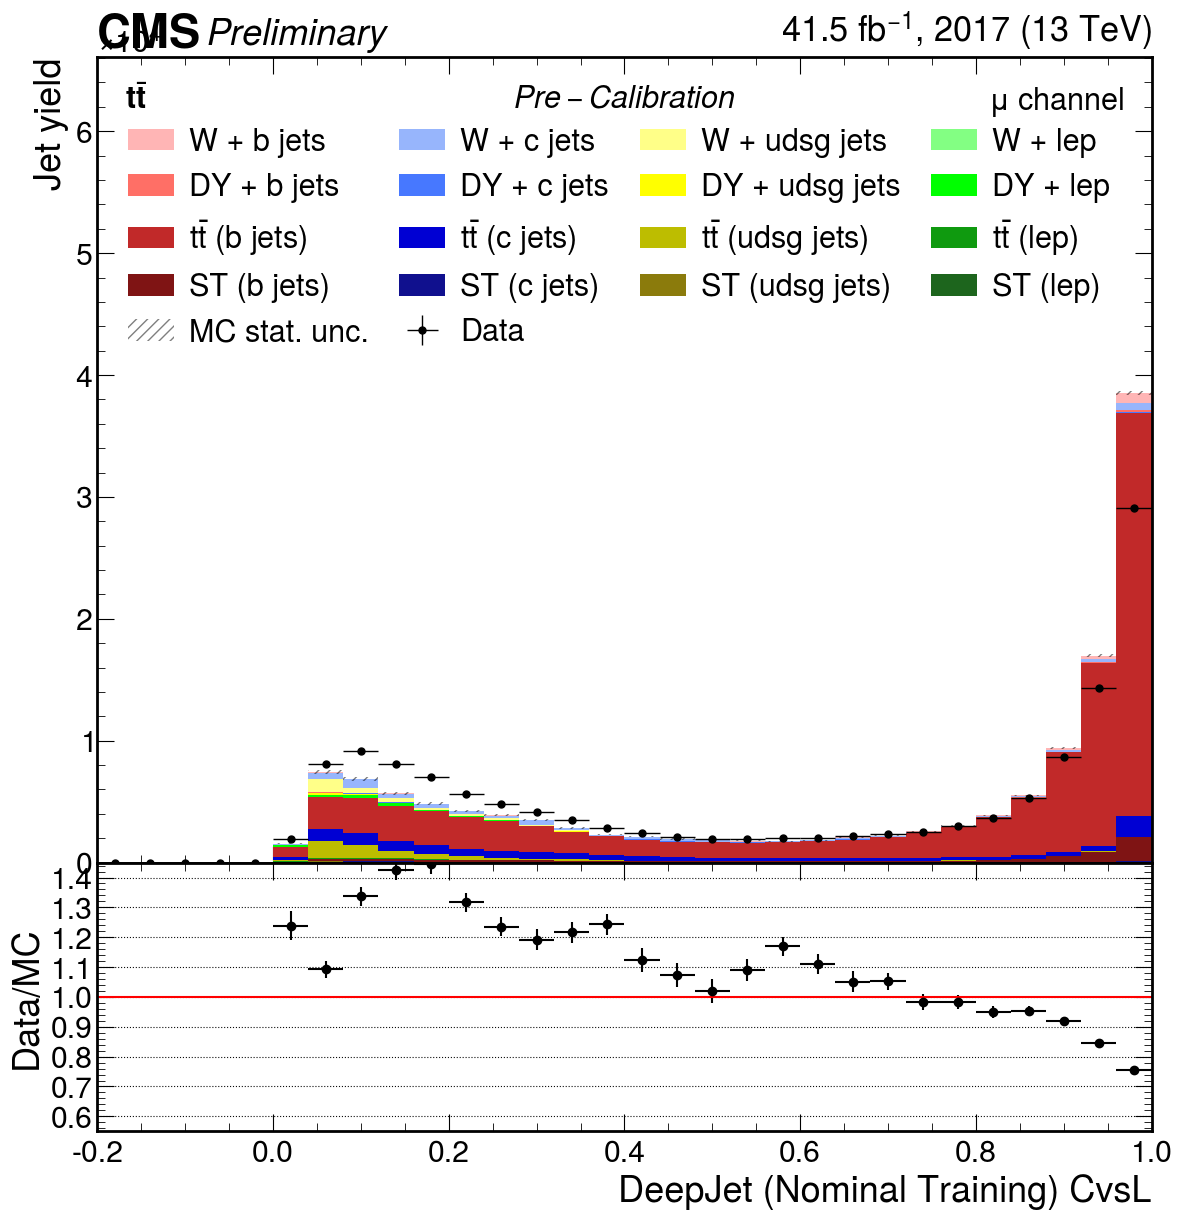

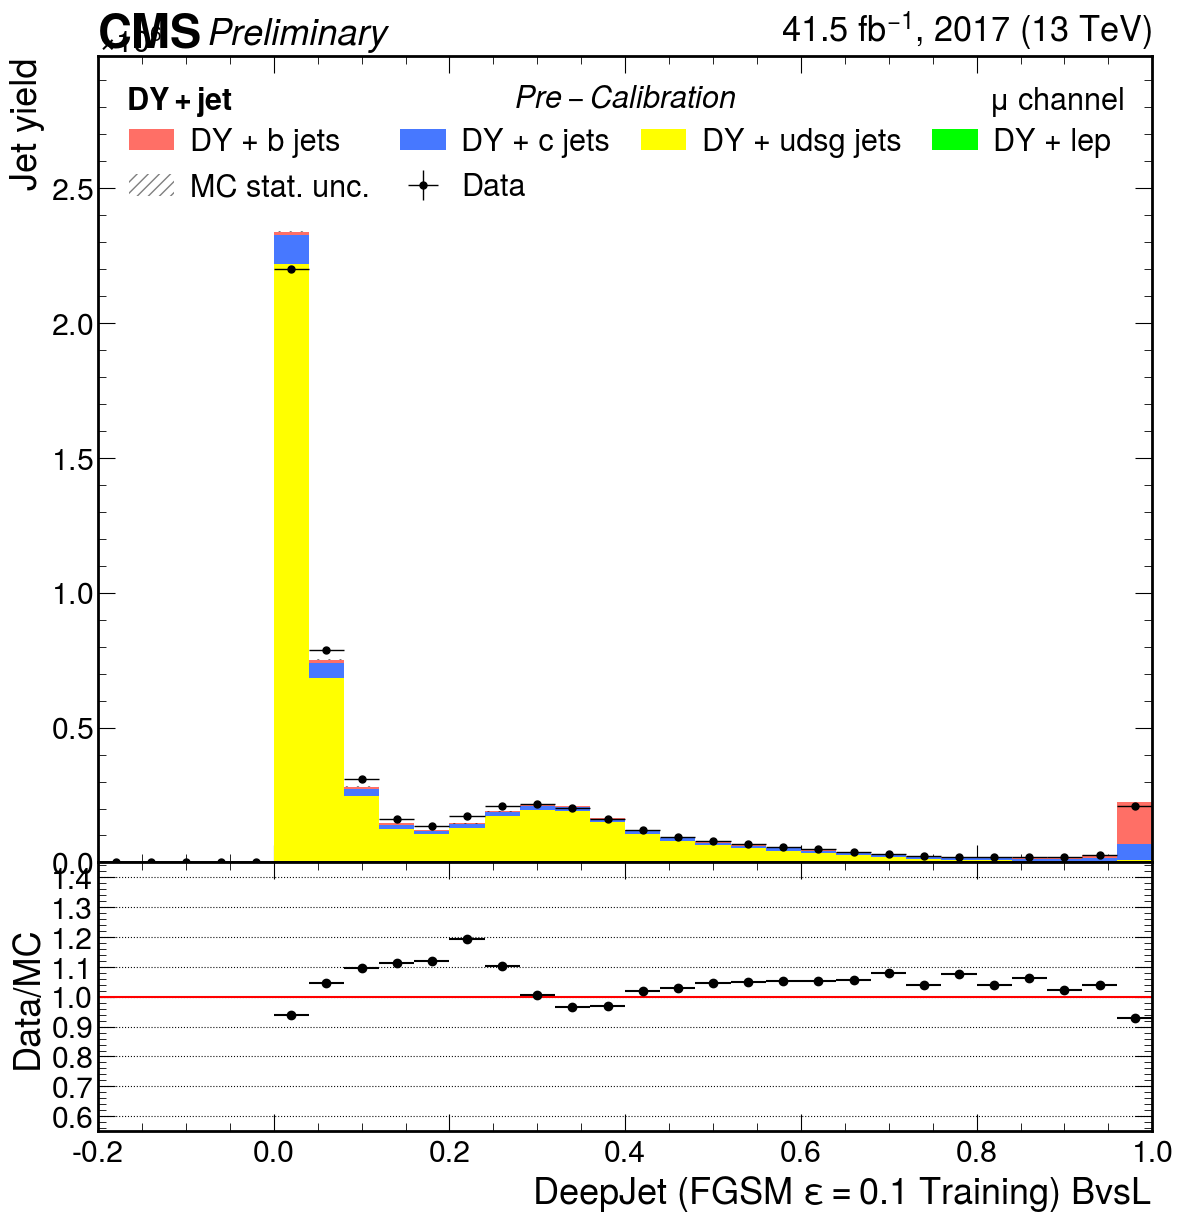

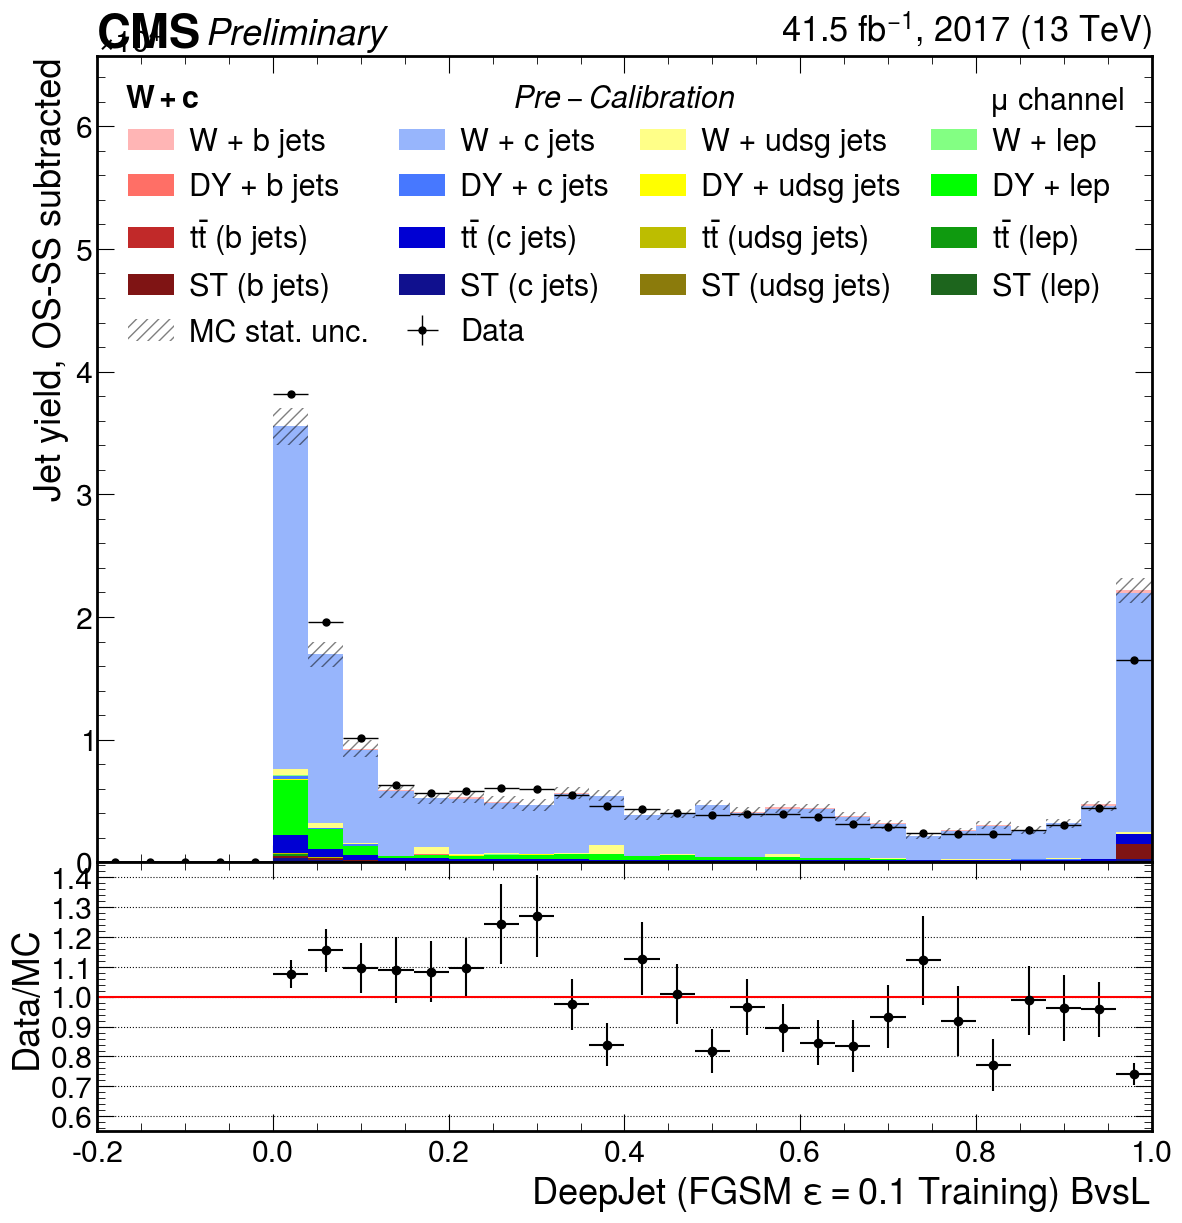

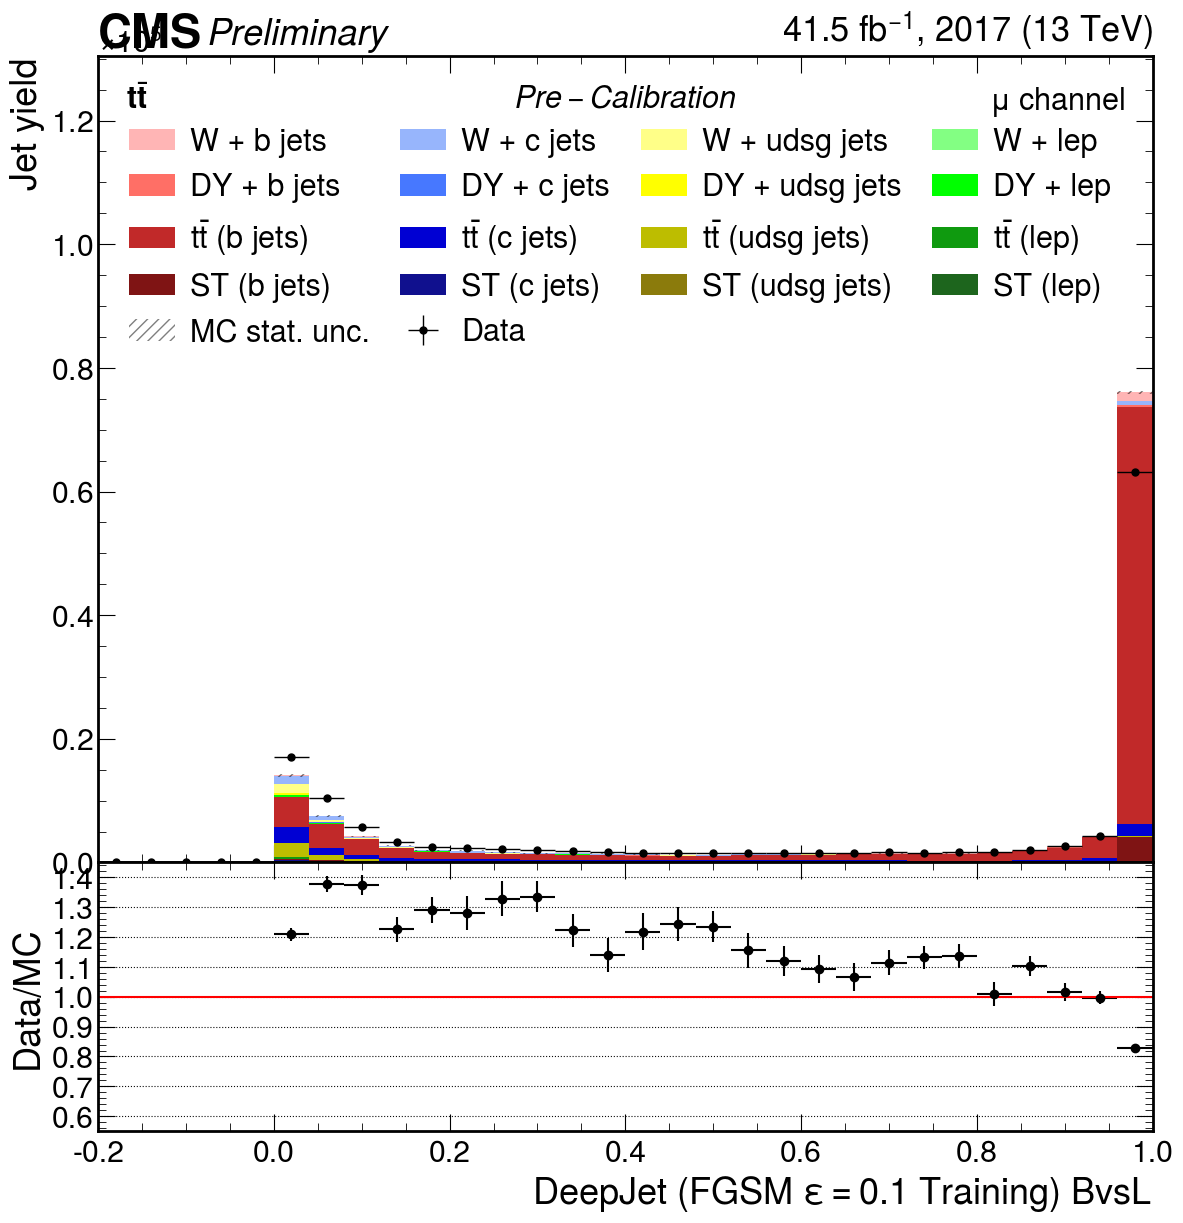

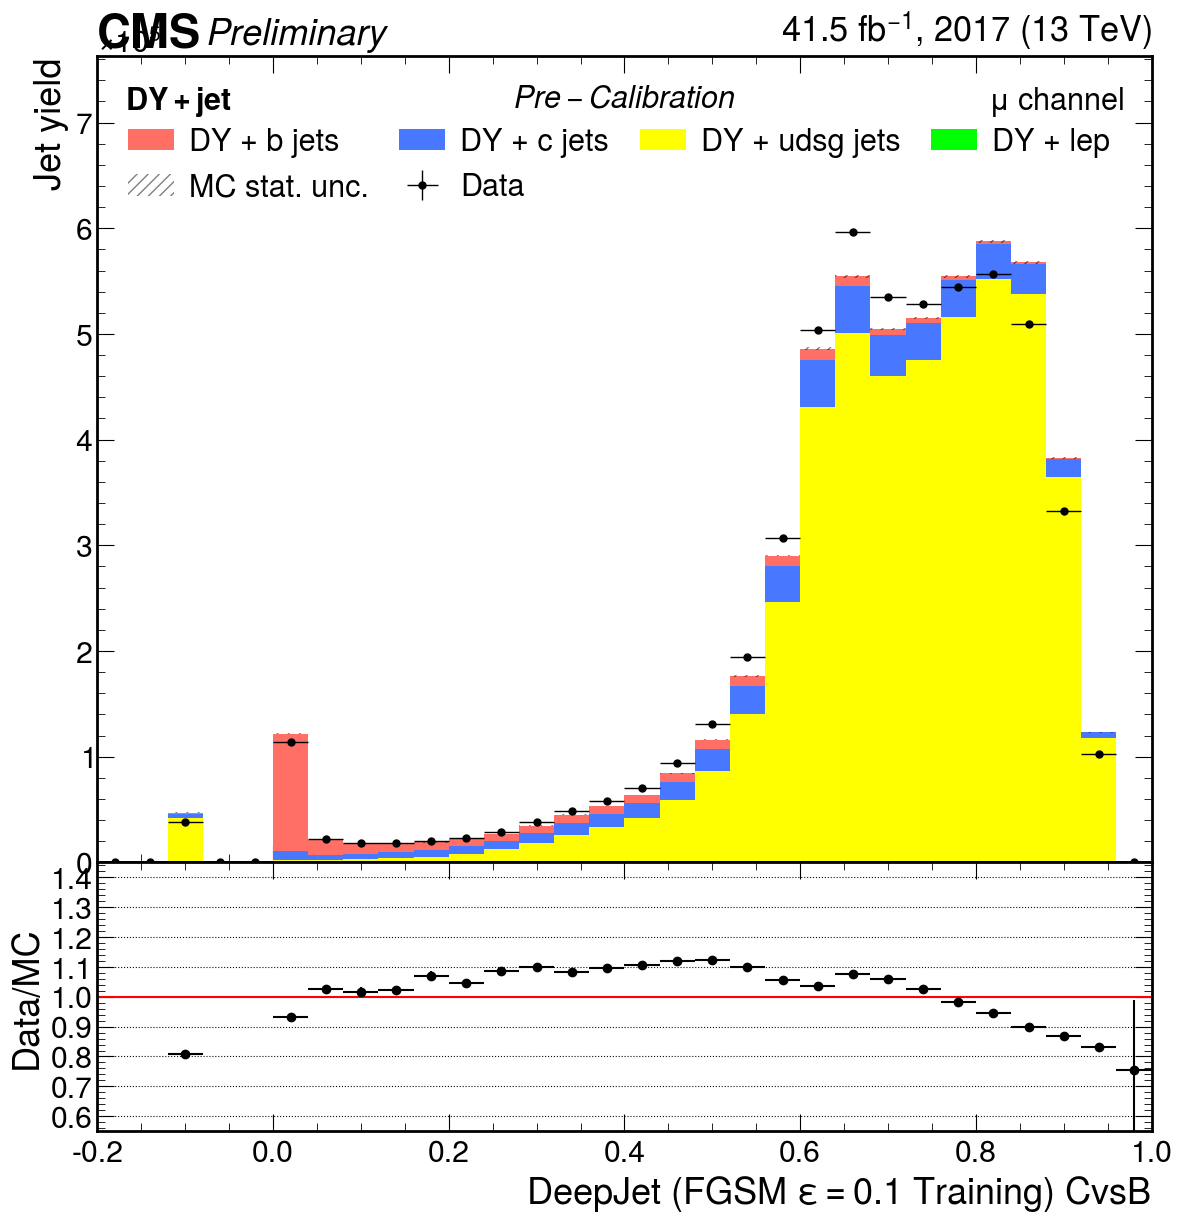

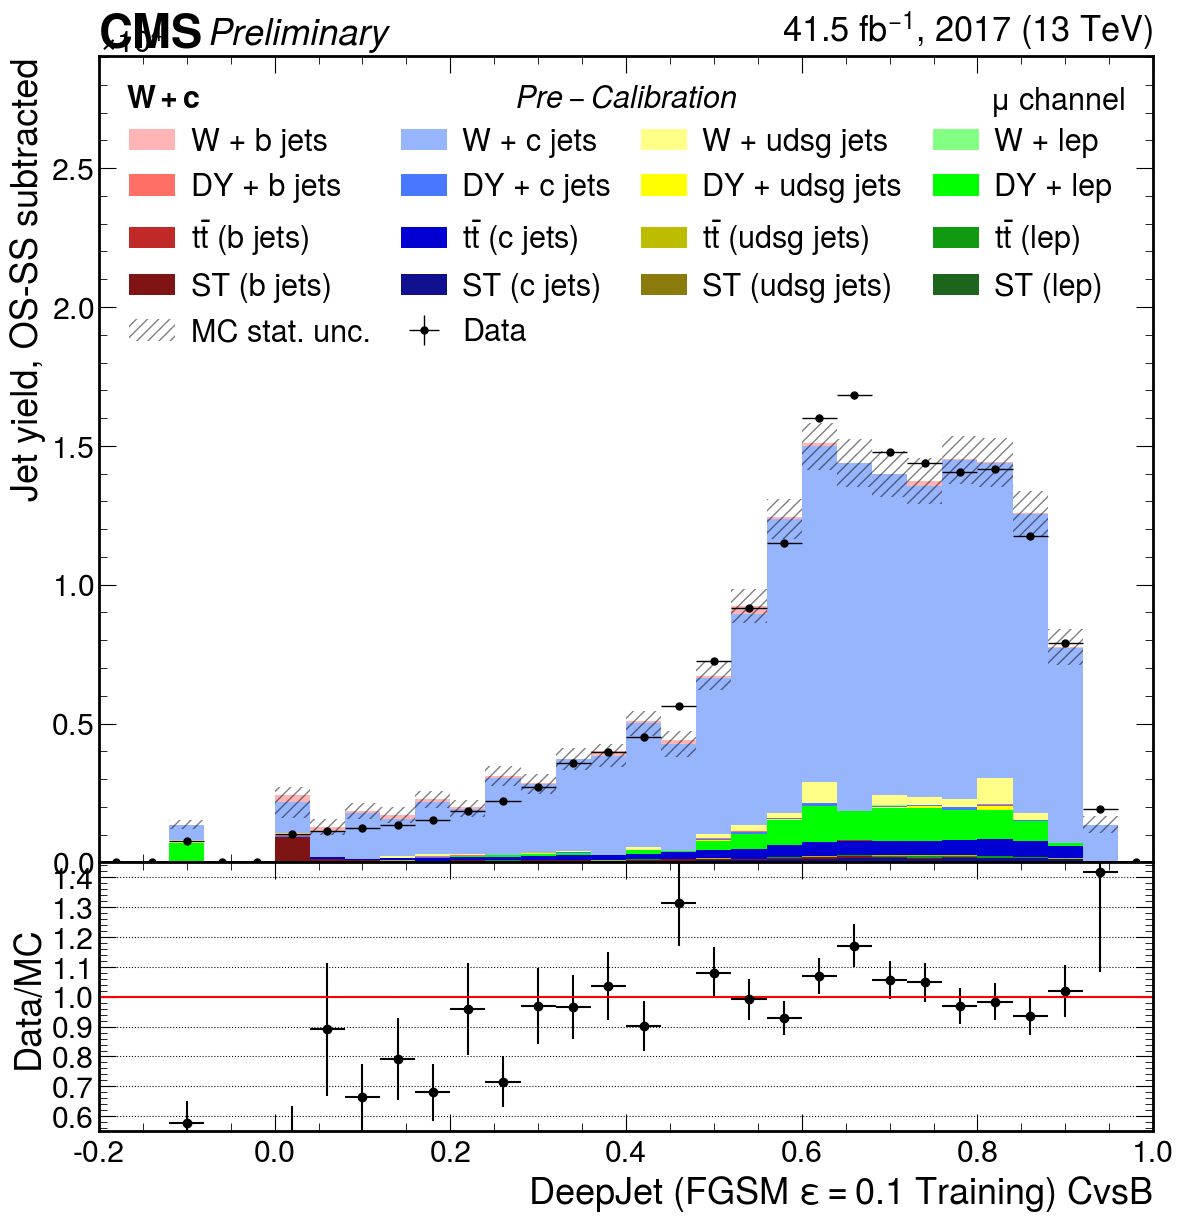

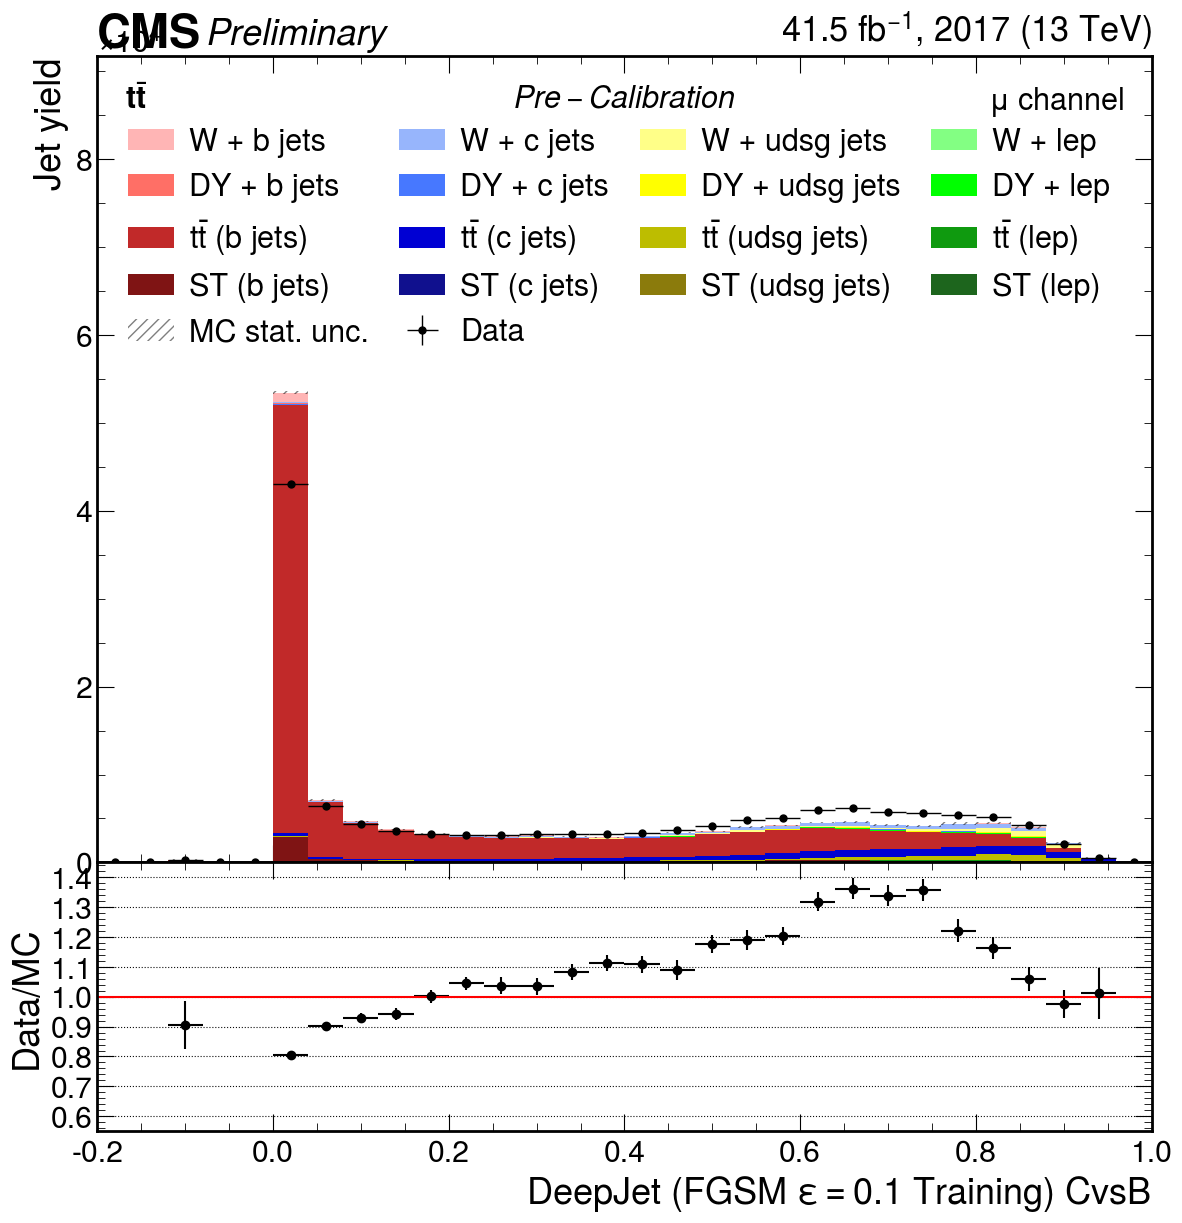

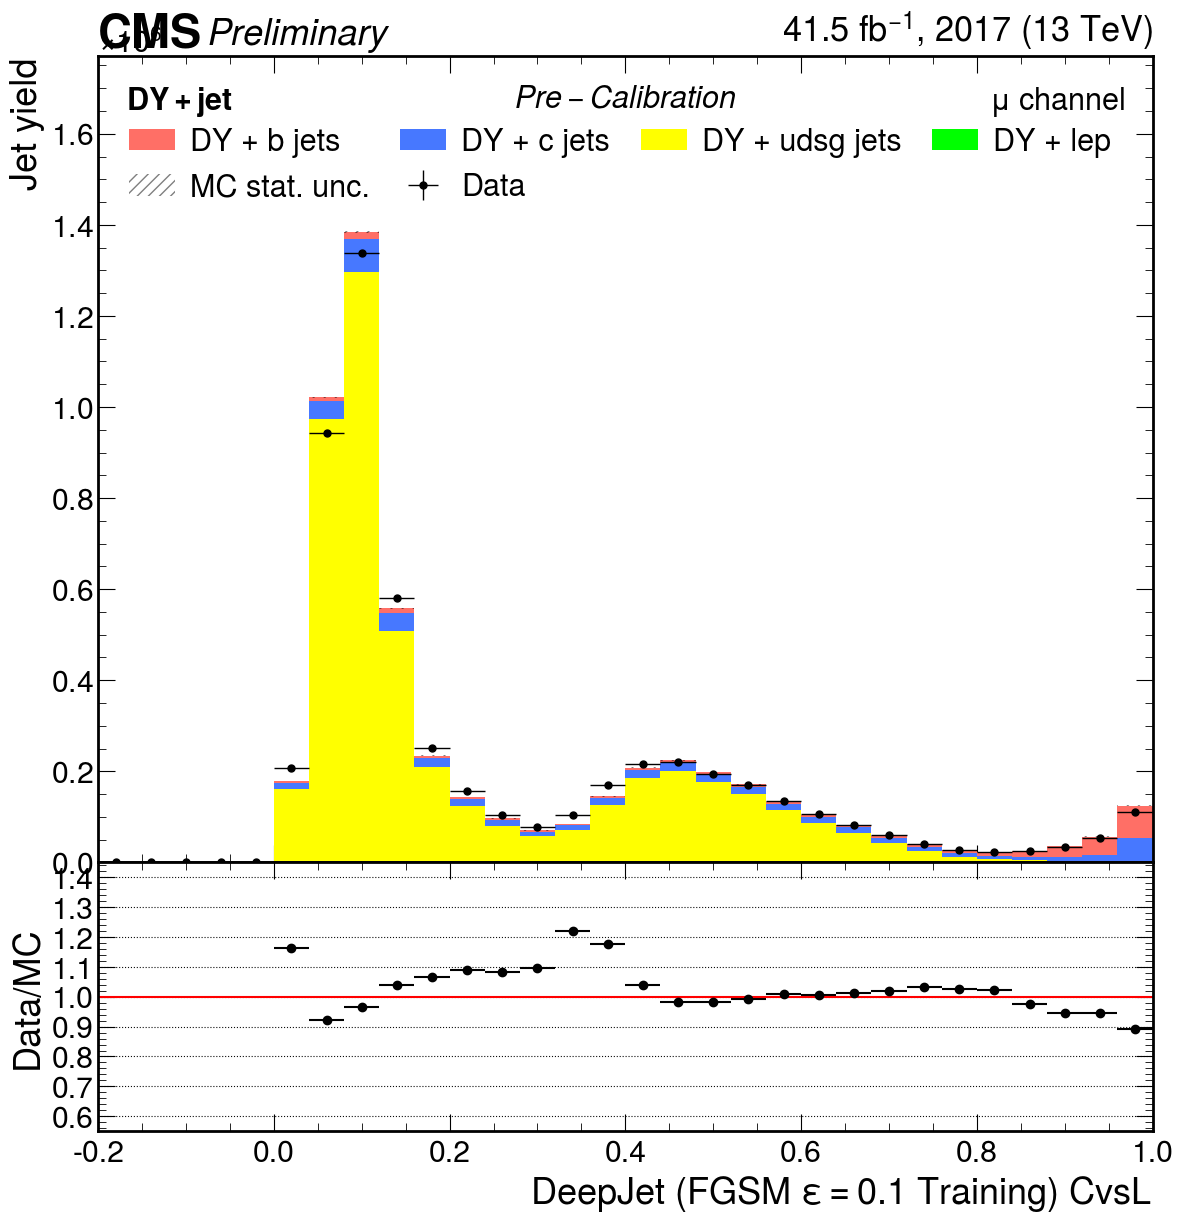

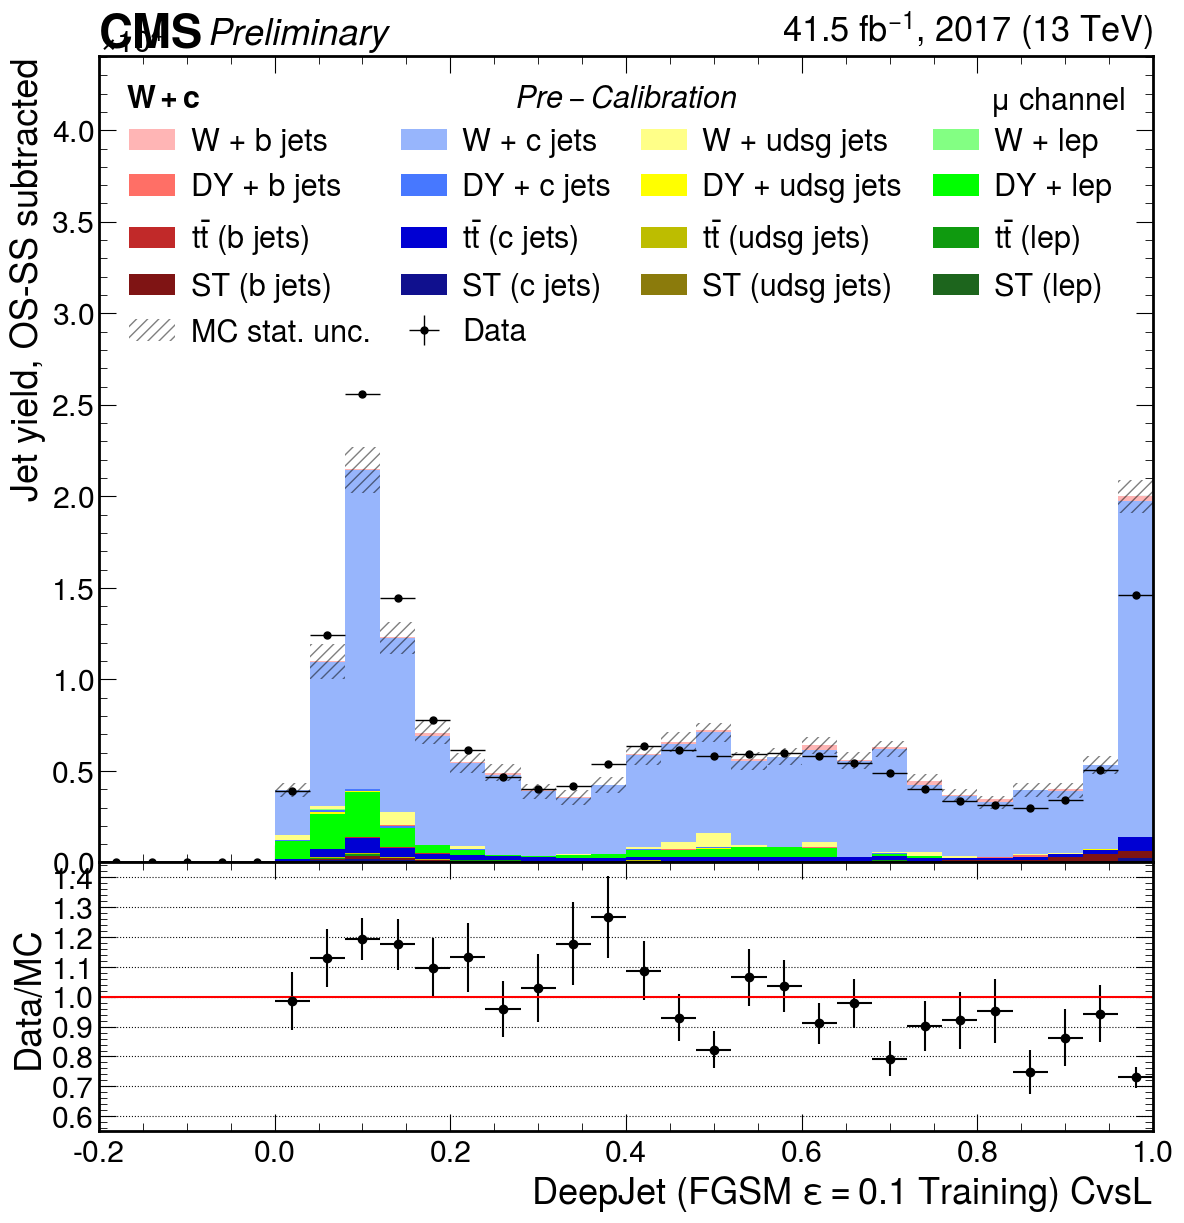

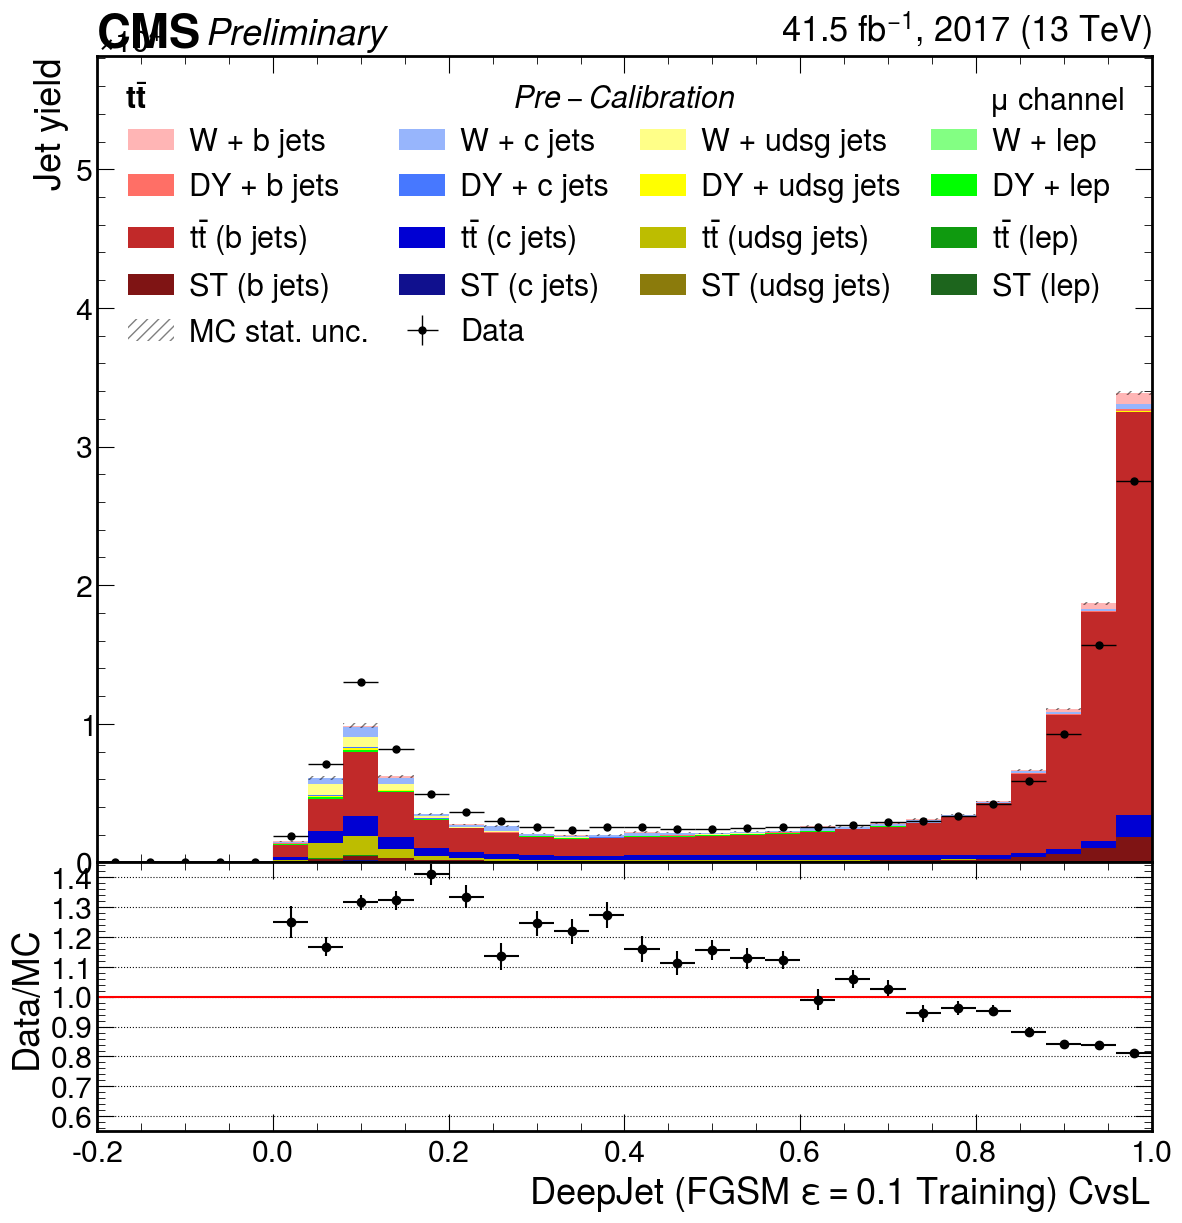

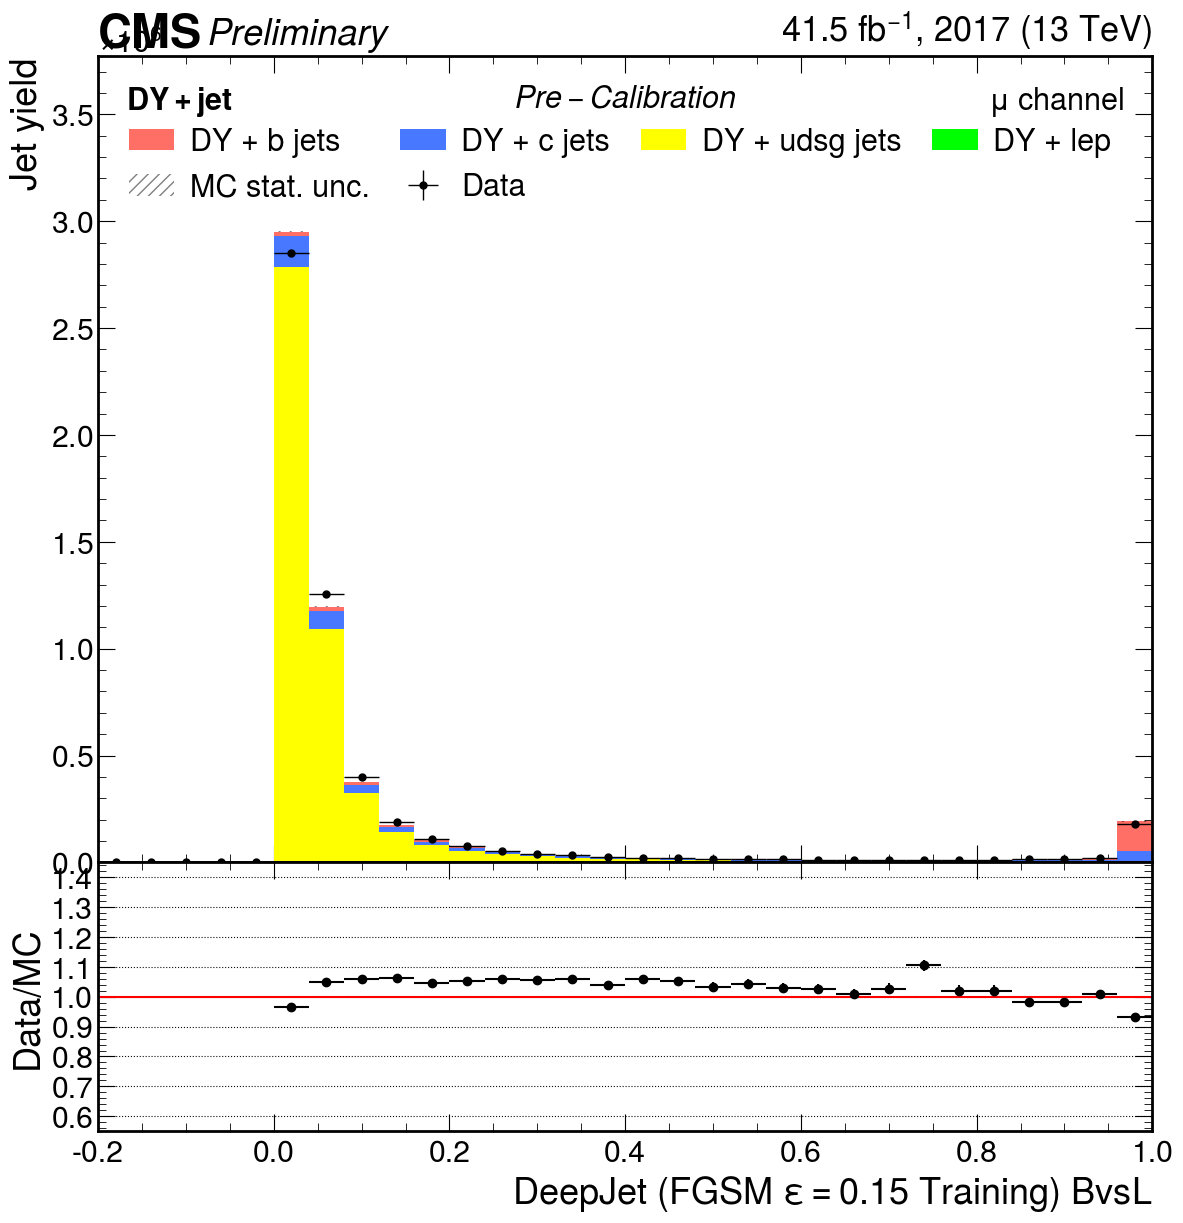

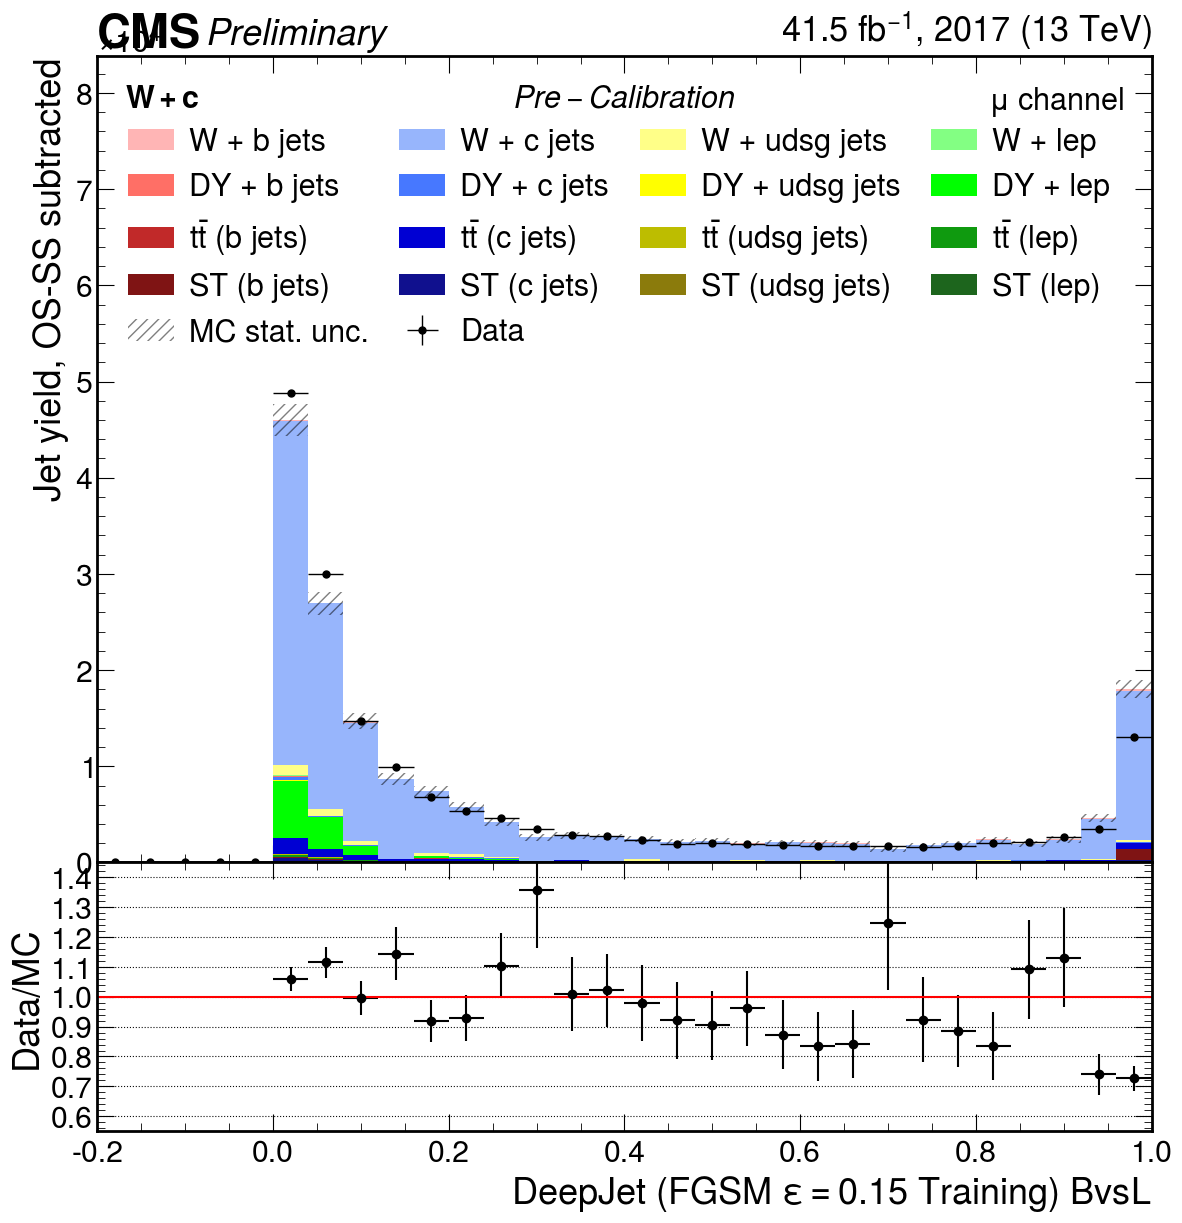

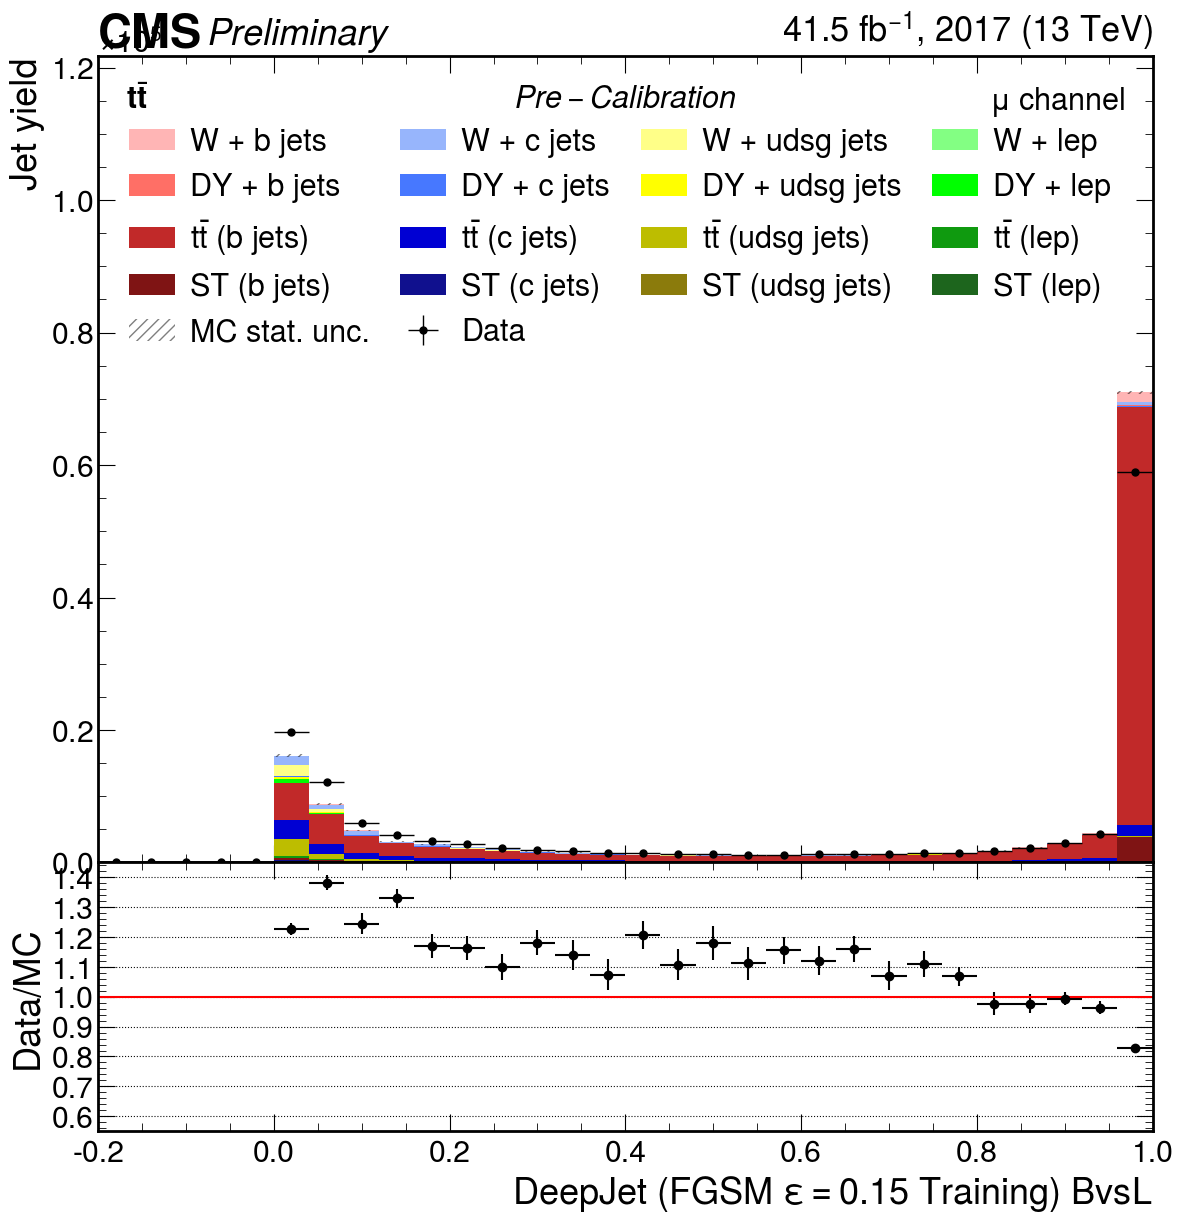

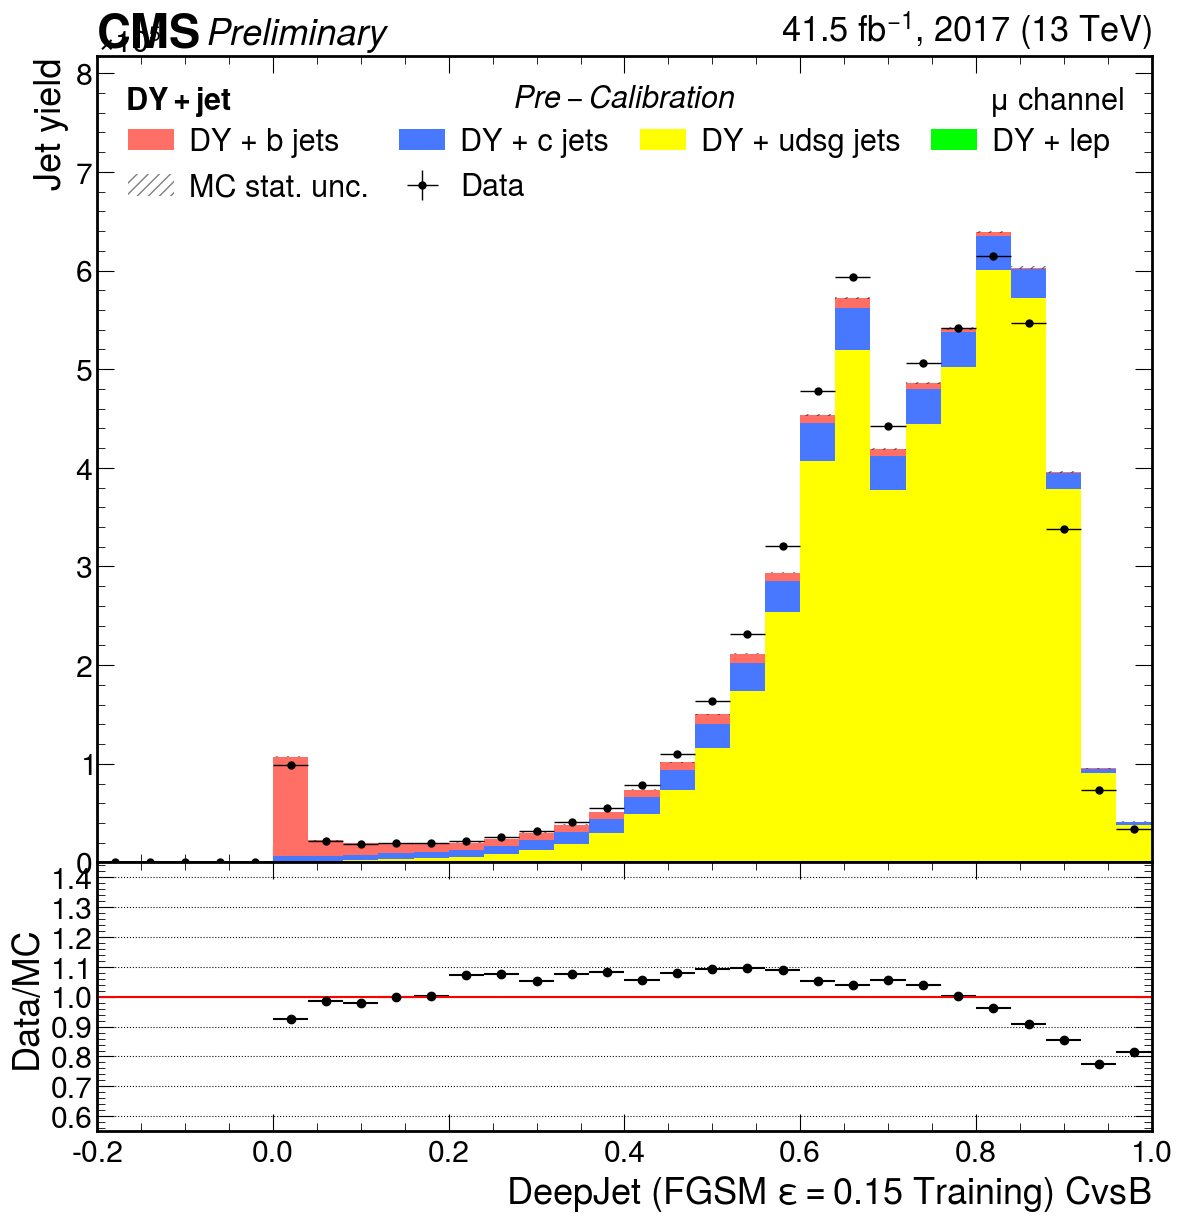

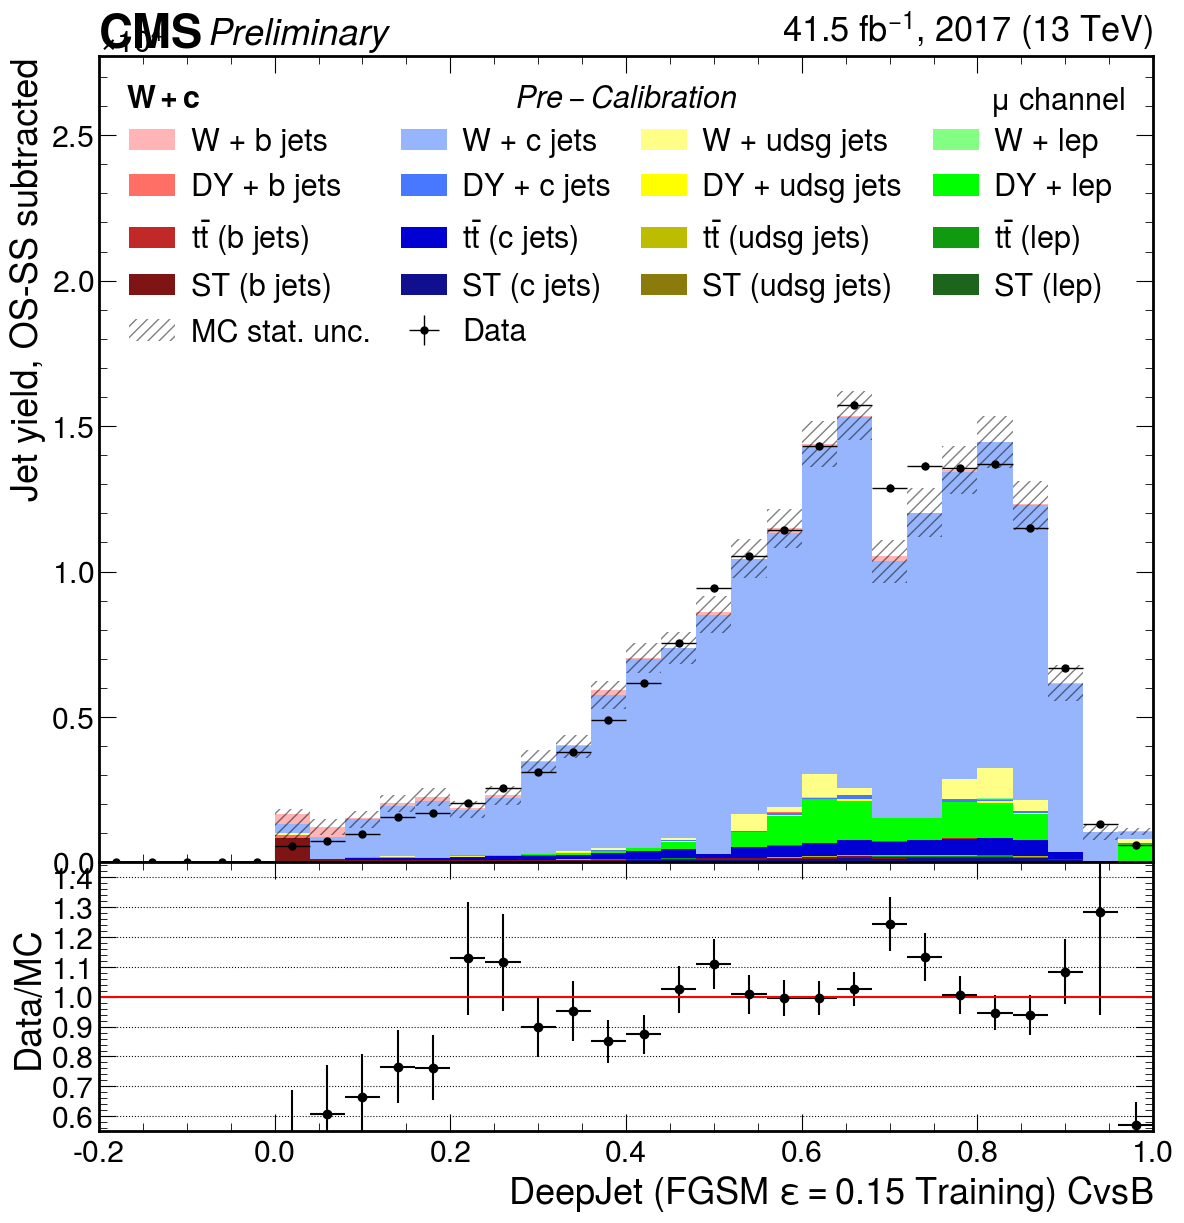

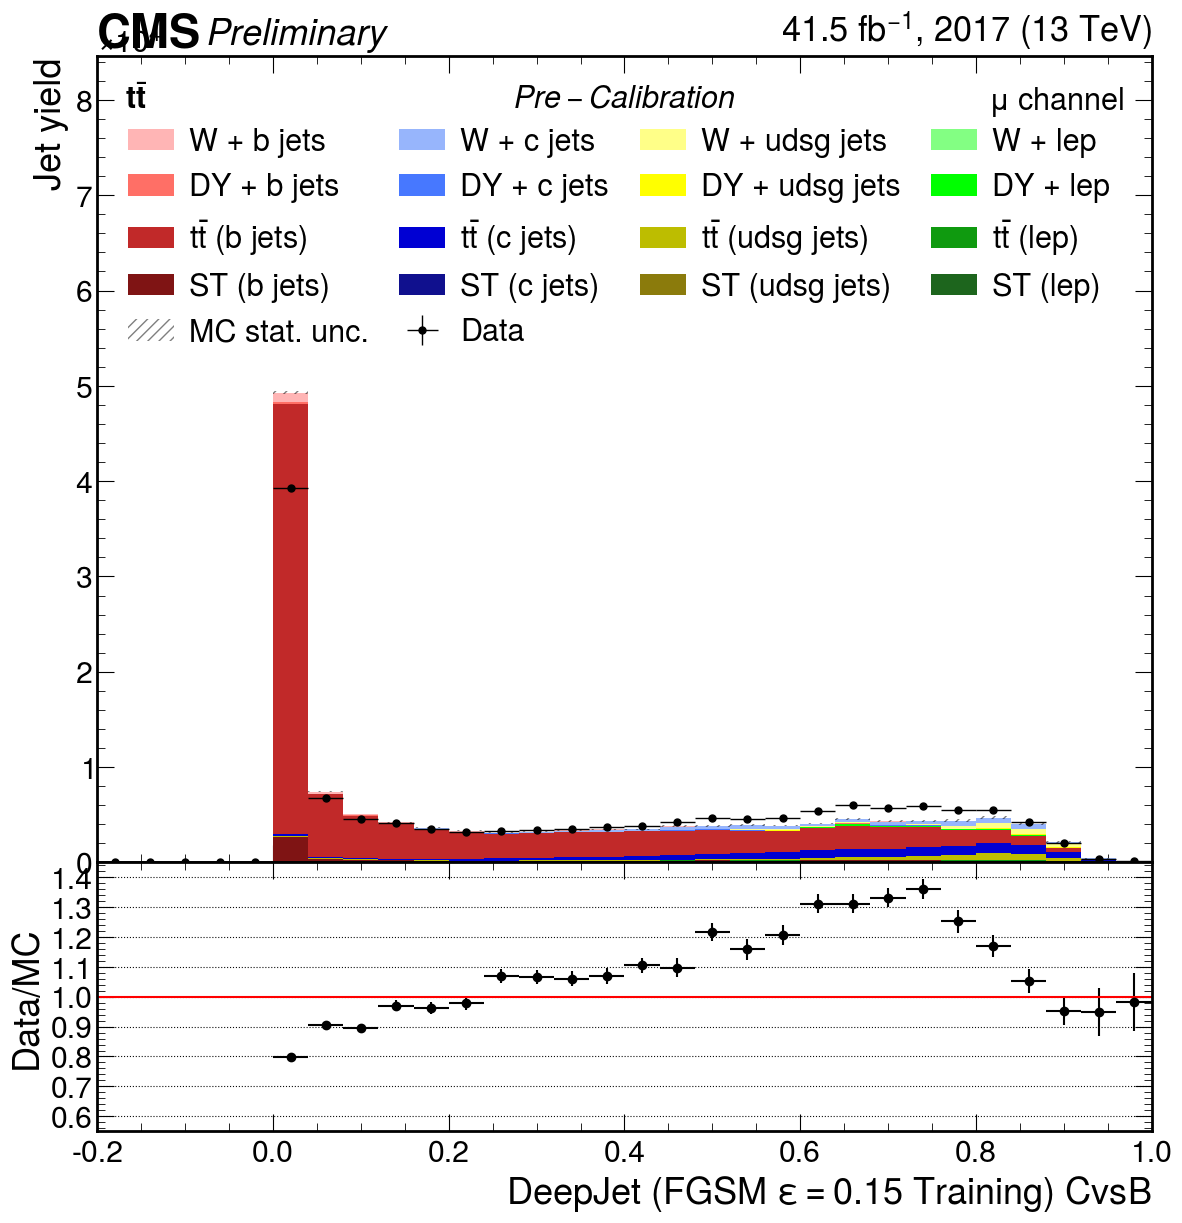

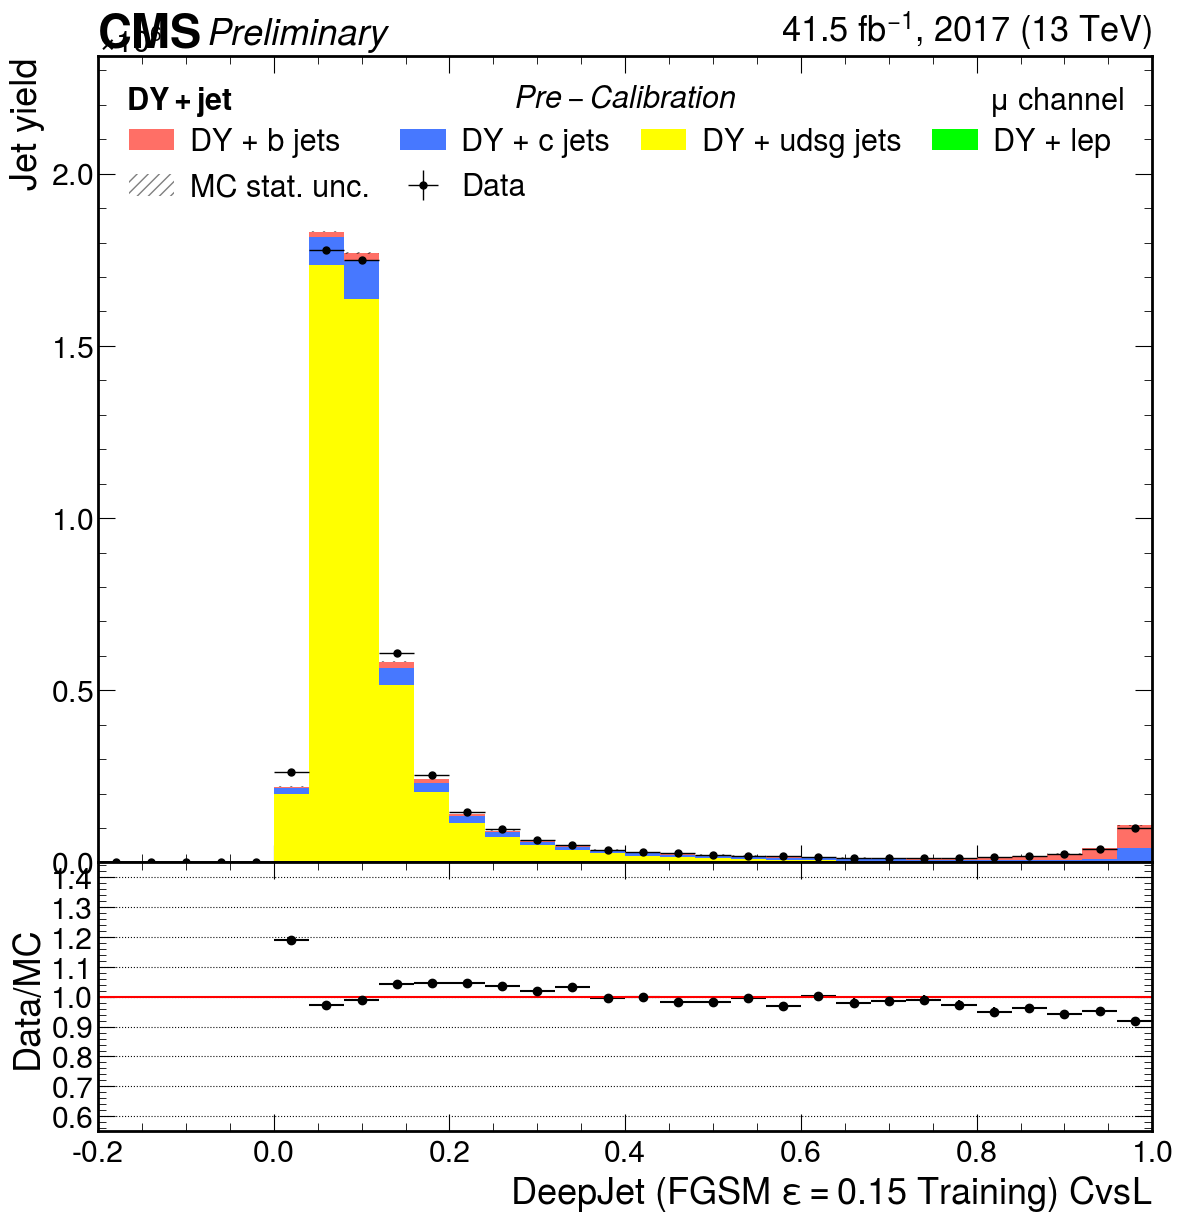

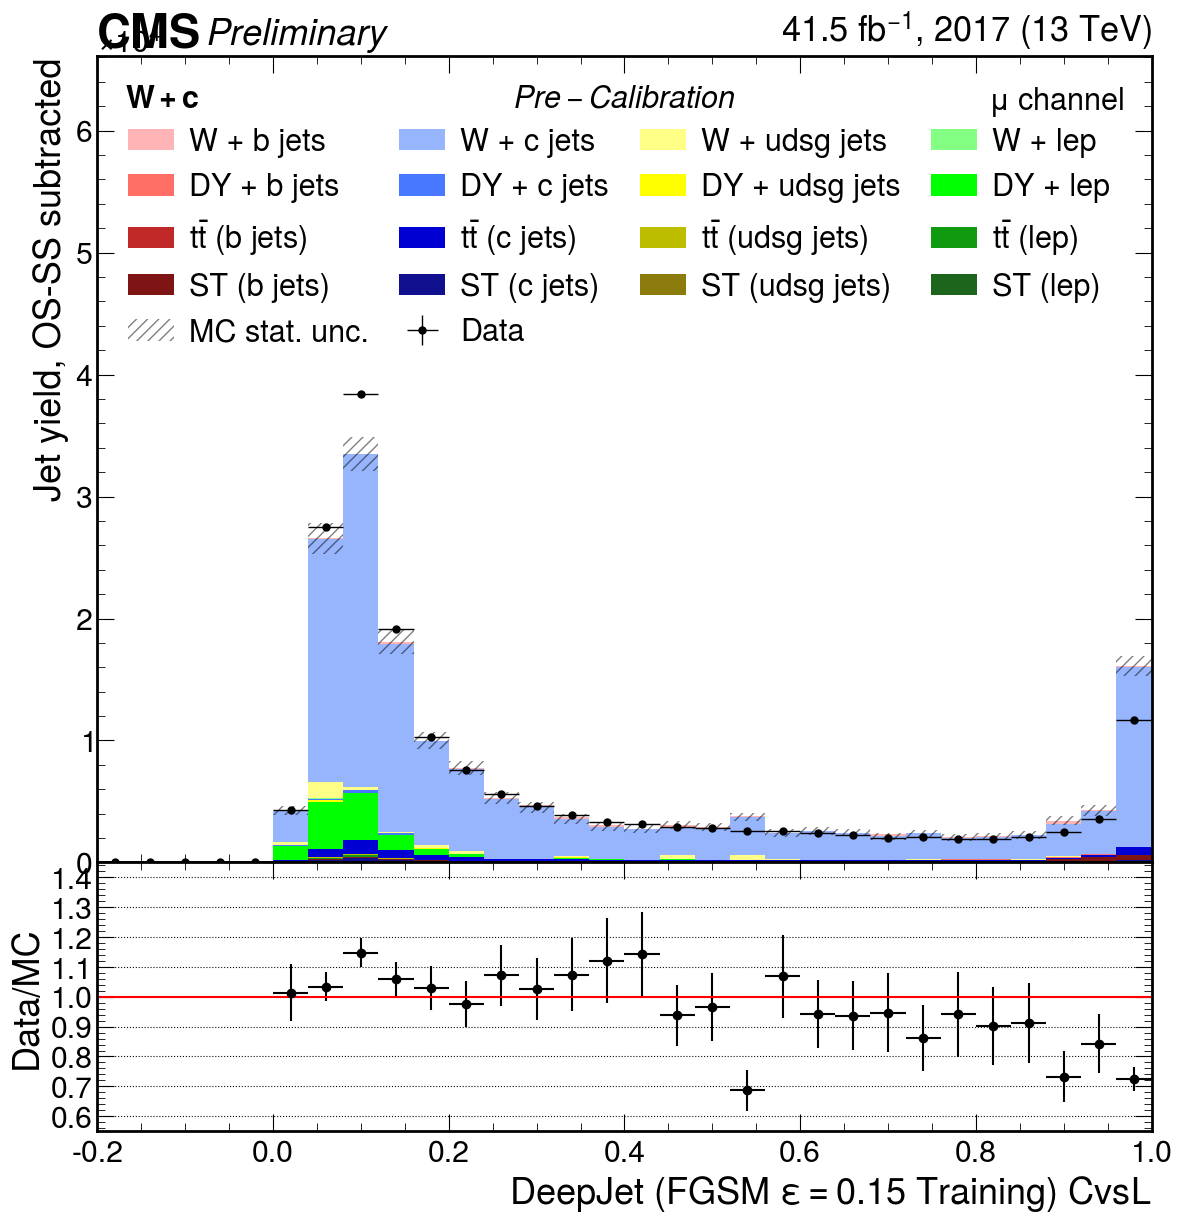

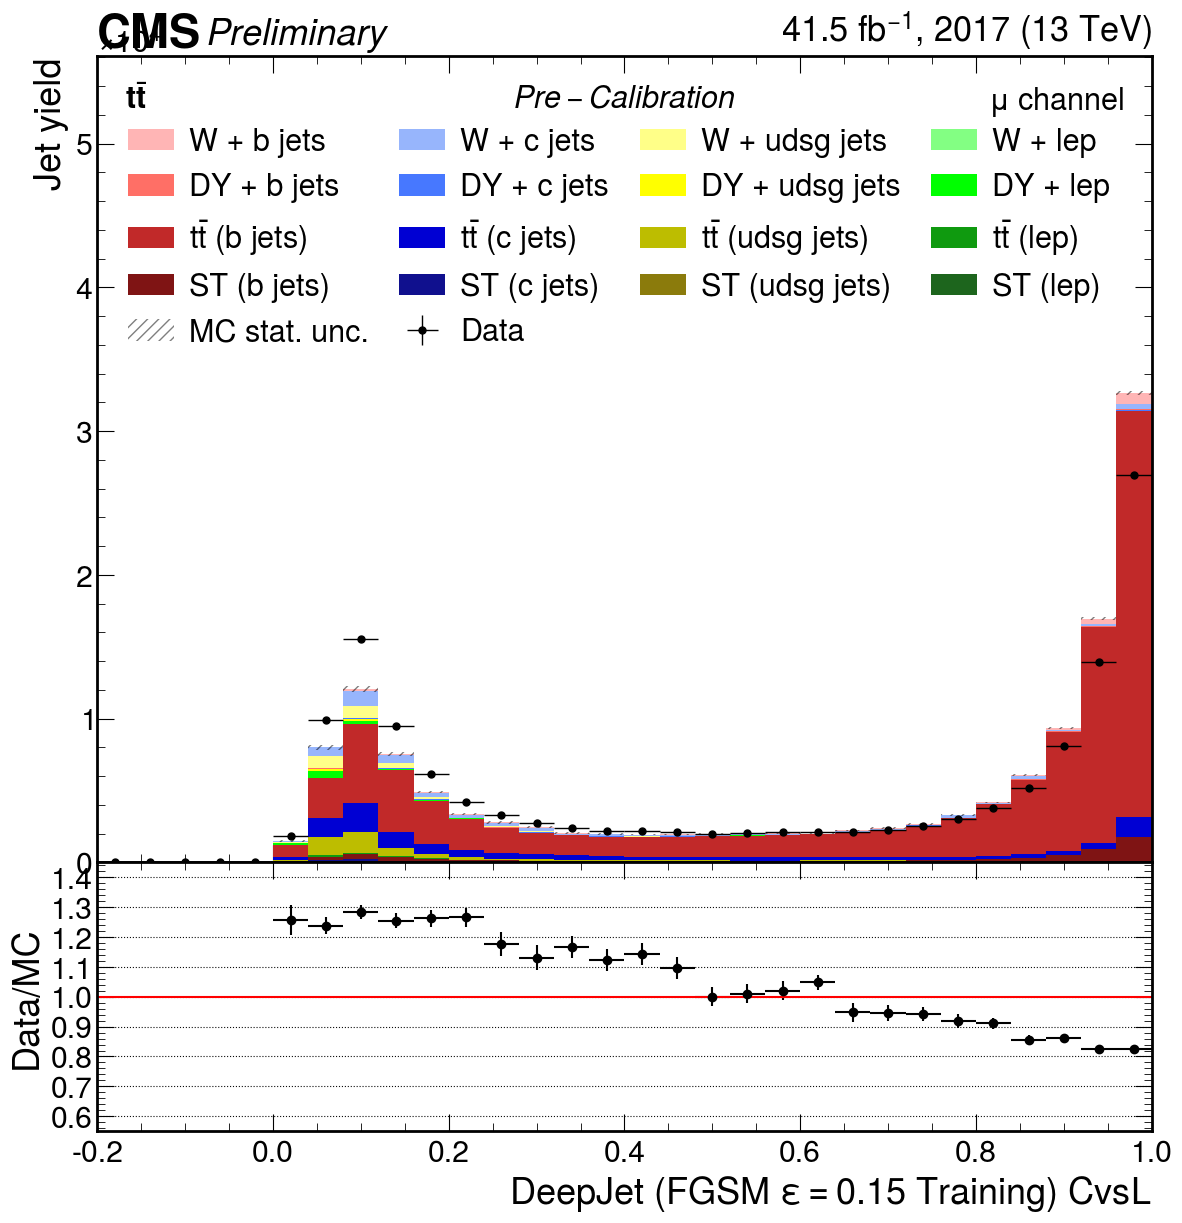

In [26]:
# create Data vs MC comparison plots
taggers = ['nominal','fgsm-0_1','fgsm-0_15',]
discriminators = ['BvsL','CvsB','CvsL']
selections = ['DY_m','Wc_m','TT_semim']

for tagger in taggers:
    for discriminator in discriminators:
        for selection in selections:
            plotStack(tagger, selection, discriminator)

In [9]:
models = ['nominal','fgsm-0_1','fgsm-0_15']#]#]
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']
include_DPnote = True # optional: include JS values from DPnote in LaTeX table?

# calculate JS divergence values for all models
js_table = np.zeros((len(models),len(selections)*len(discriminators)))
for i,model in enumerate(models):
    # nominal model is saved in the other directories
    if model=='nominal':
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{models[1]}/systPlots_2023/output_2017_PFNano_central' 
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
    for j,selection in enumerate(selections):
        for k,discriminator in enumerate(discriminators):
            if model=='nominal':
                histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
            else:
                histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
            # get Data and MC sum
            data = histo['Data'].values()
            MCsum = histo['MCSum'].values()
            #print(data)
            #print(MCsum)
            MCsum[(MCsum==0)&(data!=0)] = 0.00001
            negative_values = (data<0) | (MCsum<0)
            data[negative_values] = 0
            MCsum[negative_values] = 0 
            js_value = jsdiv(data, MCsum, normalize_first=True)
            js_table[i,j*len(discriminators)+k] = js_value
print(js_table)

[[0.00097332 0.00125668 0.00130409 0.00327636 0.00248225 0.00410233
  0.00495643 0.0033532  0.00603225]
 [0.00059299 0.00079696 0.00062263 0.00288692 0.00250177 0.00339289
  0.00496007 0.00450636 0.00474136]
 [0.00024167 0.00079017 0.00027947 0.00250824 0.00217402 0.00244578
  0.0045746  0.00448763 0.0041713 ]]


/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


In [10]:
# automatic LateX formatting
def JS_Latex(js_table, models, selections, discriminators):
    print('\\begin{table}[h]')
    print('\\label{tab:js_values}')
    print('\\caption{JS divergence values}')
    print('\\resizebox{\\textwidth}{!}{')
    tabular_line = '\\begin{tabular}{|c|'
    header_line = 'model '
    new_line = '\\\\ \\hline '
    for selection in selections:
          for discriminator in discriminators:
                tabular_line = tabular_line + 'c|'
                header_line = header_line + f'& {discriminator} '
                new_line = new_line + '&'
    new_line = new_line + ' \\\\ [-1em]'
    tabular_line = tabular_line + '}'
    header_line = header_line + new_line
    print(tabular_line)
    print('\hline')
    print(header_line)
    for i,model in enumerate(models):
        line = model_labels[model]
        for j in range(len(selections)*len(discriminators)):
            if js_table[i,j]==np.min(js_table[:,j]):
                line = line + ' & $\\textbf{'+'{:.6f}'.format(js_table[i,j])+'}$'
            else:
                line = line + ' & {:.6f}'.format(js_table[i,j])
        line = line + ' ' + new_line
        print(line)
    if include_DPnote:
        print('nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\\textbf{0.002350}$ & 0.002263 & 0.003506 & $\\textbf{0.002528}$ & 0.004820 \\\\ \\hline &&&&&&&&& \\\\[-1em]')
        print('adversarial (DPnote) & $\\textbf{0.000063}$ & $\\textbf{0.000058}$ & $\\textbf{0.000466}$ & $\\textbf{0.001887}$ & 0.003074 & $\\textbf{0.001766}$ & $\\textbf{0.003329}$ & 0.003005 & $\\textbf{0.002924}$ \\\\ \\hline')
    print('\\end{tabular}}')
    print('\\end{table}')

\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.000973 & 0.001257 & 0.001304 & 0.003276 & 0.002482 & 0.004102 & 0.004956 & $\textbf{0.003353}$ & 0.006032 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000593 & 0.000797 & 0.000623 & 0.002887 & 0.002502 & 0.003393 & 0.004960 & 0.004506 & 0.004741 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000242}$ & $\textbf{0.000790}$ & $\textbf{0.000279}$ & $\textbf{0.002508}$ & $\textbf{0.002174}$ & $\textbf{0.002446}$ & $\textbf{0.004575}$ & 0.004488 & $\textbf{0.004171}$ \\ \hline &&&&&&&&& \\ [-1em]
nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\textbf{0.002350}$ & 0.002263 & 0.003506 & $\textbf{0.002528}$ & 0.004820 \\ \hline &&&&&&&&& \\[-1em]

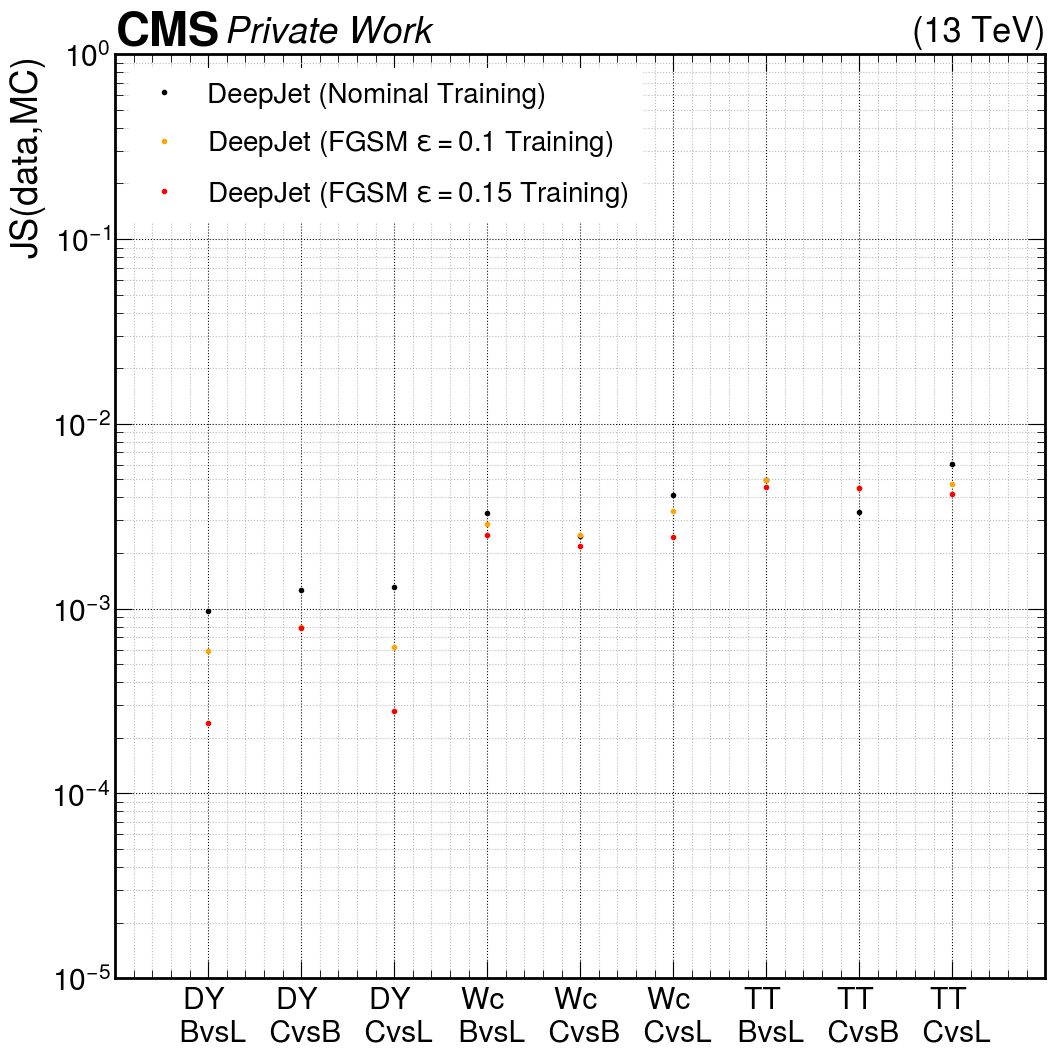

In [12]:
# Plotting the JS divergence values:
model_colors = {
    'nominal': 'black',
    'fgsm-0_1': 'orange',
    'fgsm-0_15': 'red',
}
def PlotJS(js_table, models, selection, discriminators):
    fig,ax = plt.subplots(figsize=[12,12])
    plt.style.use(hep.cms.style.ROOT)
    ax.set_xlim(left=0.,right=10)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.00001,top=1)
    ax.set_ylabel('JS(data,MC)')
    #ax.set_xlabel('Discriminator')
    ax.grid(which='minor', alpha=0.85)
    ax.grid(which='major', alpha=0.95, color='black')
    # choose arbitrary positions to place the JS values
    x = [1,2,3,4,5,6,7,8,9]
    # set x ticks
    labels = ['DY \n BvsL','DY \n CvsB','DY \n CvsL','Wc \n BvsL','Wc \n CvsB','Wc \n CvsL','TT \n BvsL','TT \n CvsB','TT \n CvsL']
    ax.set_xticks(x,labels)
    for i,model in enumerate(models):

        ax.plot(x, js_table[i,:], label=model_labels[model], color=model_colors[model], marker='.', linestyle='None')
    # make legend
    leg = ax.legend(title='',loc='upper left',ncols=1,fontsize=20,title_fontsize=20,labelspacing=0.7,frameon=True,framealpha=1,facecolor='white')
    leg._legend_box.align = 'left'
    leg.get_frame().set_linewidth(0.0)
    hep.cms.label(llabel='Private Work',rlabel='(13 TeV)')
    fig.savefig(save_dir + 'JS_values.pdf', bbox_inches='tight')
    fig.savefig('JS_values.pdf', bbox_inches='tight')

In [4]:
discriminators = ['BvsL','CvsB','CvsL']
selections = ['DY_m','Wc_m','TT_semim']
jet_index = {
    'DY_m': '0',
    'Wc_m': 'muJet_idx',
    'TT_semim': 'muJet_idx',
}


for selection in selections:
    for discriminator in discriminators:
        histo = uproot.open(path+f'{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
        print(histo.keys())
        # get Data and MC sum
        data = histo['Data'].values()
        data_err = histo['Data'].errors()
        MCsum = histo['MCSum'].values()
        MCsum_err = histo['MCSum'].errors()
        print(data)
        print(data_err)
        print(MCsum)
        print(MCsum_err)
        # get values of DY+jet jets
        DYJets_b = histo['DYJets_b'].values()
        DYJets_c = histo['DYJets_c'].values()
        DYJets_uds = histo['DYJets_uds'].values()
        DYJets_lep = histo['DYJets_lep'].values()
        if selection != 'DY_m':
            # get values of W+jet jets
            WJets_b = histo['WJets_b'].values()
            WJets_c = histo['WJets_c'].values()
            WJets_uds = histo['WJets_uds'].values()
            WJets_lep = histo['WJets_lep'].values()
            WJets_lep = histo['WJets_lep'].values()
            # get values of ttbar jets
            ttbar_b = histo['ttbar_b'].values()
            ttbar_c = histo['ttbar_c'].values()
            ttbar_uds = histo['ttbar_uds'].values()
            ttbar_lep = histo['ttbar_lep'].values()
            # get values of single top jets
            ST_b = histo['ST_b'].values()
            ST_c = histo['ST_c'].values()
            ST_uds = histo['ST_uds'].values()
            ST_lep = histo['ST_lep'].values()

['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[      0.       0.       0.       0.       0. 2277797.  583194.  295269.
  205423.  201377.  212819.  172893.  154343.  139412.  134929.  142450.
  143232.  131363.  106126.   79586.   59140.   47444.   37200.   27816.
   21194.   16998.   15738.   16933.   22751.  188148.]
[   0.            0.            0.            0.            0.
 1509.23722456  763.6713953   543.38660271  453.23614154  448.75048746
  461.32309719  415.80404038  392.8651168   373.37916385  367.32682995
  377.42548934  378.46003752  362.44033992  325.76985741  282.10990766
  243.18717071  217.81643648  192.87301522  166.78129392  145.58159224
  130.37637823  125.45118573  130.12686118  150.83434622  433.76030247]
[      0.               0.               0.               0.
       0.         2484276.22765037  514787.28195412  249784.74178359
  189378.94770242  200066.67249609  207353.96540026  161943.96

In [18]:
model = 'fgsm-0_1'
selection = 'Wc'
channel = 'SingleMuon'
file = 'outTree_Run2017C-UL2017_MiniAODv2-v1_PFNanoFromMiniV2WithParT_0_2.root'

path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/2017_{selection}_DeepJet_Run2_COMPLETE/{channel}/'
tree = uproot.open(path+file)

print(tree.keys())
keys = tree['Events'].keys()

for key in keys:
    print(tree['Events'][key].keys())
    print(tree['Events'][key].values())

['h_postp;1', 'Events;1', 'h_total;1', 'h_nEvent;1']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

In [42]:
print('\hline n')

\hline n
